In [1]:
from Utils import utils, plot
from Utils.train_batched_A2C import *
from Utils.A2C_inspection import *
from Utils.inspection_plots import *
import AC_modules.Networks as net
from AC_modules.BatchedA2C import MoveToBeaconSpatialA2C

import torch
import numpy as np
import matplotlib.pyplot as plt

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


# Load training session to inspect

In [2]:
load_dir = "Results/MoveToBeacon/"
queries = ['ESEK.npy']
train_dict = utils.load_session(load_dir, queries)

Number of matching filenames: 1
 ['S_batched-A2C_conv-net_lr-7e-4_20-steps_no-queued_1.2M-env-steps_240-unroll-len_ESEK.npy']


In [101]:
game_params = train_dict['game_params']
HPs = train_dict['HPs']
score = train_dict['score']
losses = train_dict['losses']
keywords = train_dict['keywords']
ID = keywords[-1]
print("HPs: ", HPs)

HPs:  {'action_space': 3, 'gamma': 0.99, 'n_steps': 20, 'H': 0.001, 'spatial_model': <class 'AC_modules.Networks.FullyConvSpatial'>, 'nonspatial_model': <class 'AC_modules.Networks.FullyConvNonSpatial'>, 'n_features': 256, 'n_channels': 32, 'spatial_dict': {'in_channels': 2}, 'nonspatial_dict': {'resolution': 16}, 'device': 'cuda'}


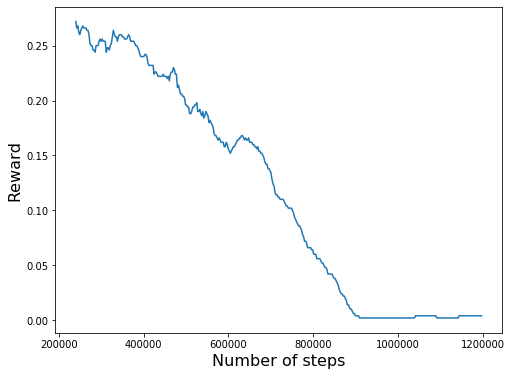

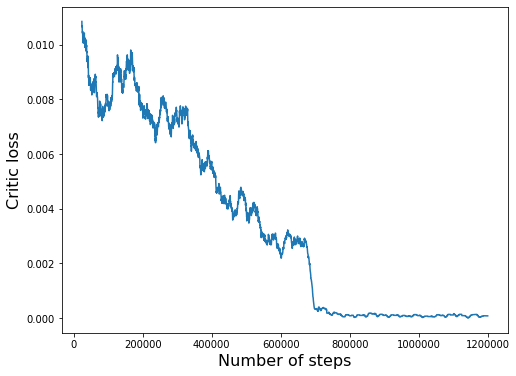

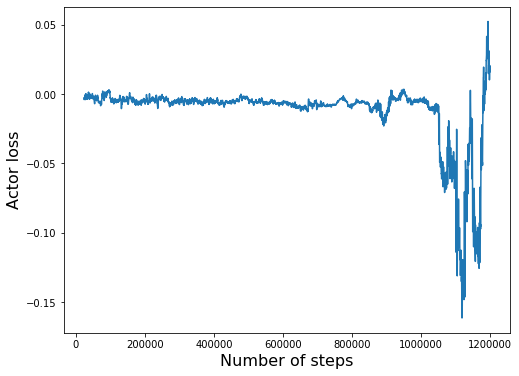

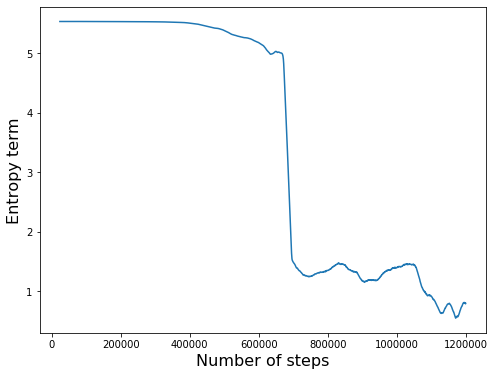

In [103]:
plot.plot_bA2C_session(score, losses, unroll_length=240, test_interval=10, moving_average=True, average_window=10)

# Update variables visualization 

First of all search for the step nearest to the point that we want to inspect

In [34]:
n = 25
step_idx =  0 + n*4800
step_idx

120000

In [35]:
load_dir = "Results/MoveToBeacon/Inspection/"
PID = "JCMN"
step_idx = step_idx
insp_dict = np.load(load_dir+PID+"_"+str(step_idx)+".npy", allow_pickle=True).item()

In [36]:
insp_dict.keys()

dict_keys(['state_traj', 'rewards', 'action_distr', 'action_sel', 'queue_distr', 'queue_sel', 'selectall_distr', 'selectall_sel', 'spatial_distr', 'spatial_sel', 'values', 'trg_values', 'critic_losses', 'advantages', 'actor_losses'])

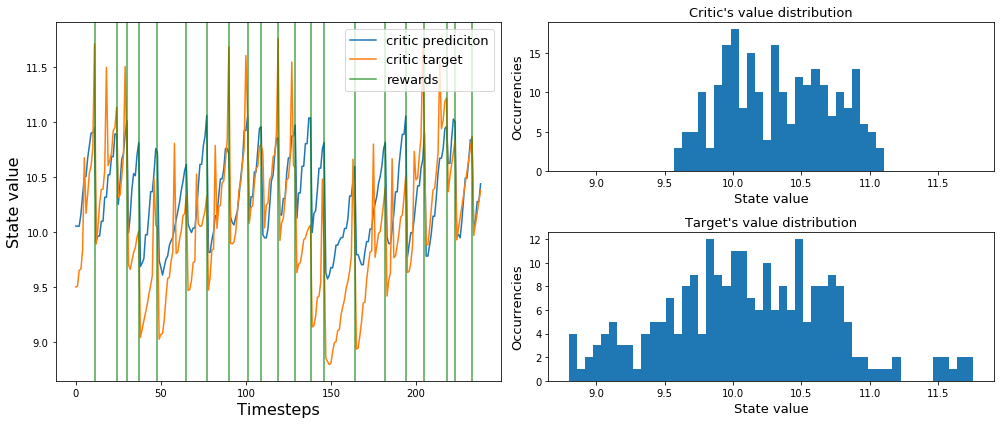

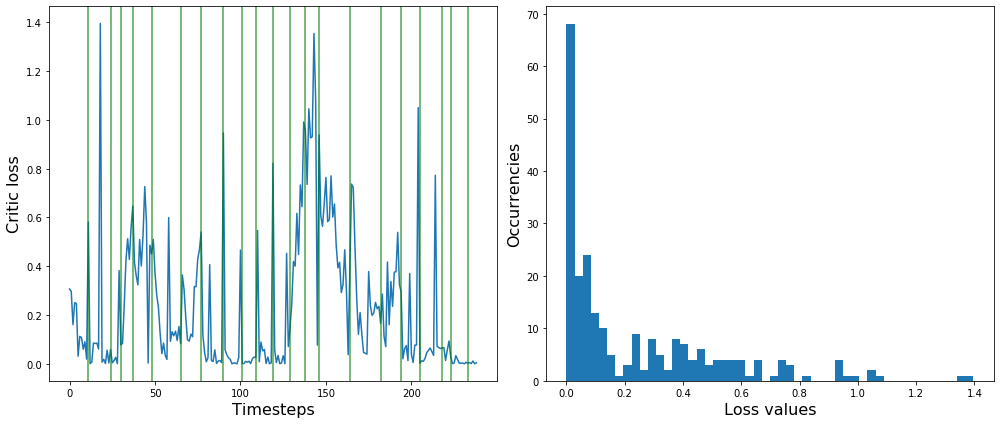

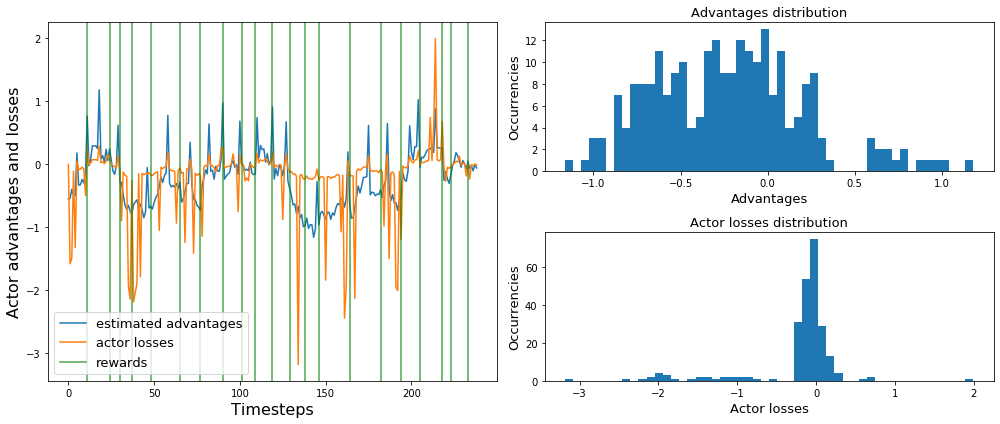

In [37]:
plot_update_curves(insp_dict)

In [23]:
#plot_update_curves(insp_dict, 55, 90)

# Frame by frame visualization

Coordinates:
1. Map works with y and then x
2. Actions work with x and then y


Step 0
_NO_OP: 	1.27
_SELECT_ARMY:  98.73 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   0.00 - _NOT_QUEUED: 98.62 - POINT: (x,y)=(0,0)
Action selected:  [1]
State value: 10.0553
Move advantage: -0.5538


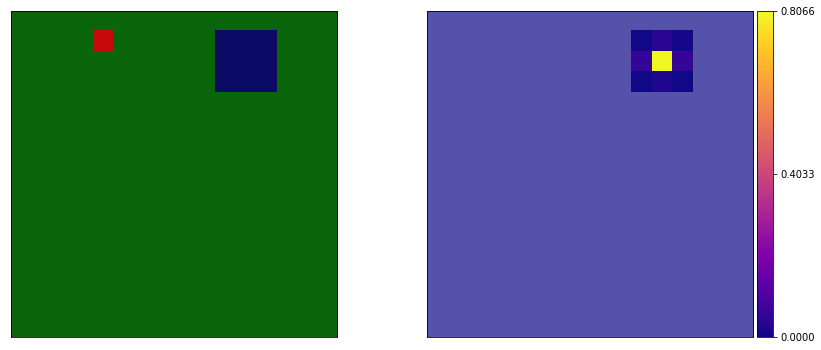


Step 1
_NO_OP: 	0.00
_SELECT_ARMY:  0.01 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.62 - POINT: (x,y)=(10,2)
Action selected:  [2]
State value: 10.0553
Move advantage: -0.5447


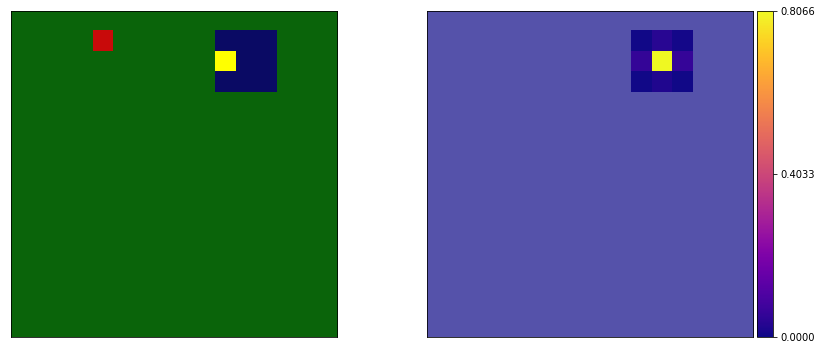


Step 2
_NO_OP: 	0.00
_SELECT_ARMY:  0.01 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.62 - POINT: (x,y)=(11,3)
Action selected:  [2]
State value: 10.0553
Move advantage: -0.4008


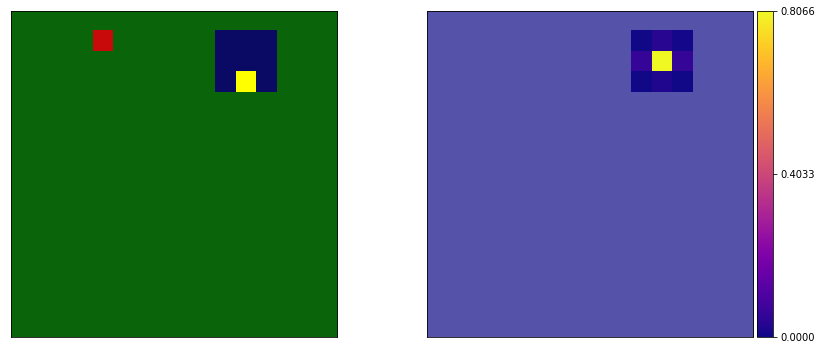


Step 3
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.68 - POINT: (x,y)=(11,2)
Action selected:  [2]
State value: 10.1647
Move advantage: -0.5009


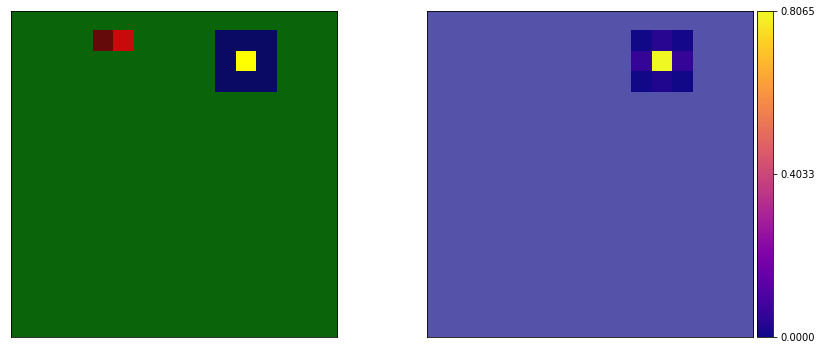


Step 4
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.77 - POINT: (x,y)=(10,2)
Action selected:  [2]
State value: 10.3386
Move advantage: -0.4970


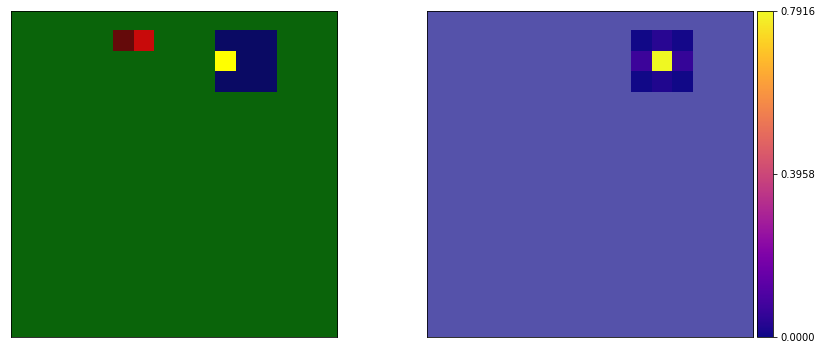


Step 5
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.85 - POINT: (x,y)=(11,2)
Action selected:  [2]
State value: 10.5005
Move advantage: 0.1767


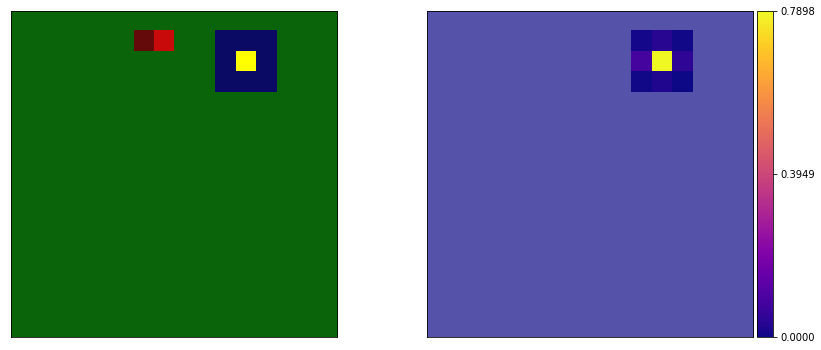


Step 6
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.86 - POINT: (x,y)=(11,2)
Action selected:  [2]
State value: 10.5071
Move advantage: -0.3352


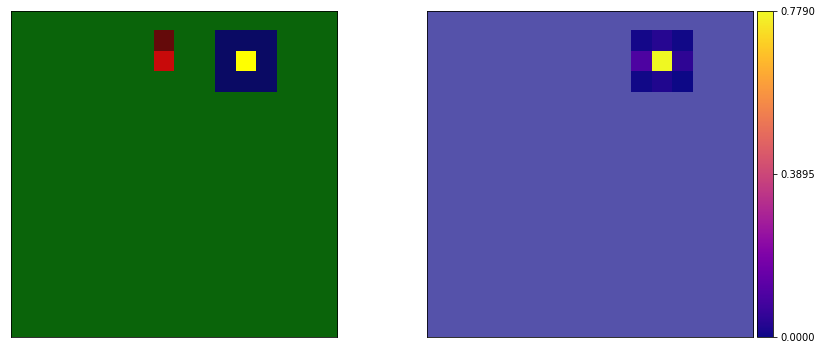


Step 7
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.93 - POINT: (x,y)=(11,2)
Action selected:  [2]
State value: 10.6769
Move advantage: -0.3279


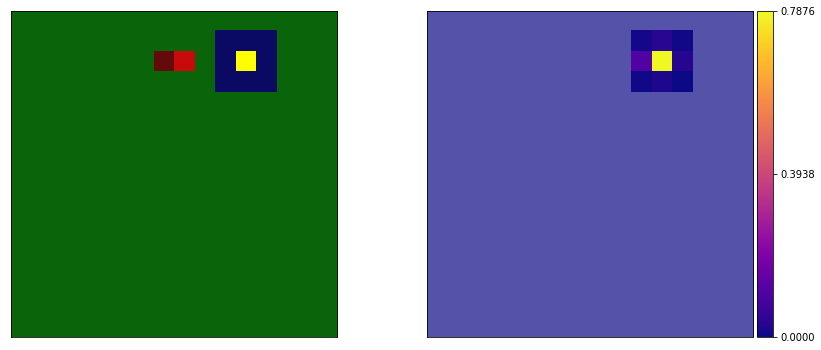


Step 8
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.98 - POINT: (x,y)=(11,2)
Action selected:  [2]
State value: 10.7863
Move advantage: -0.2448


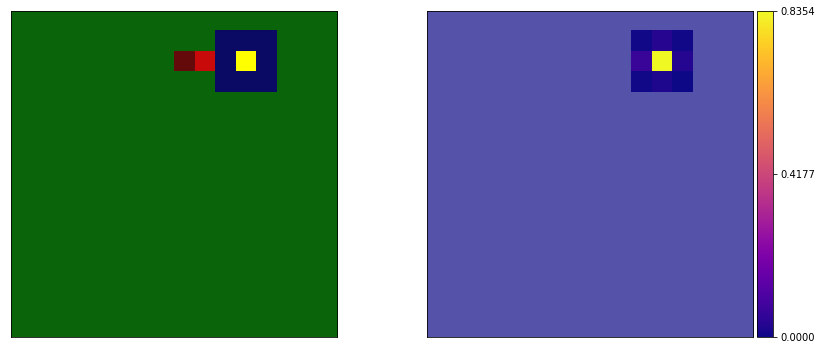


Step 9
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 99.03 - POINT: (x,y)=(11,2)
Action selected:  [2]
State value: 10.9024
Move advantage: -0.3000


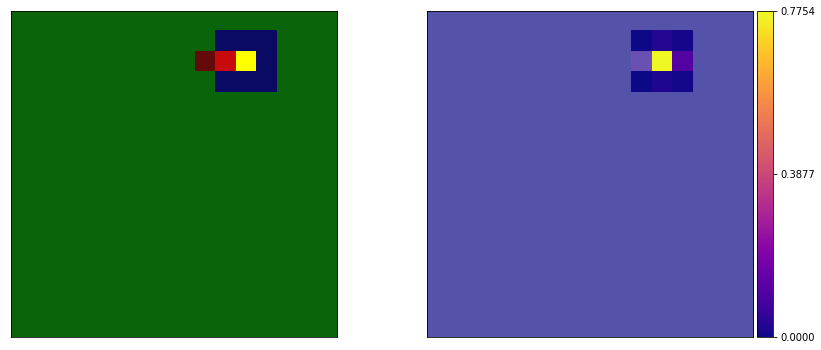


Step 10
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 99.03 - POINT: (x,y)=(11,1)
Action selected:  [2]
State value: 10.9024
Move advantage: -0.1384


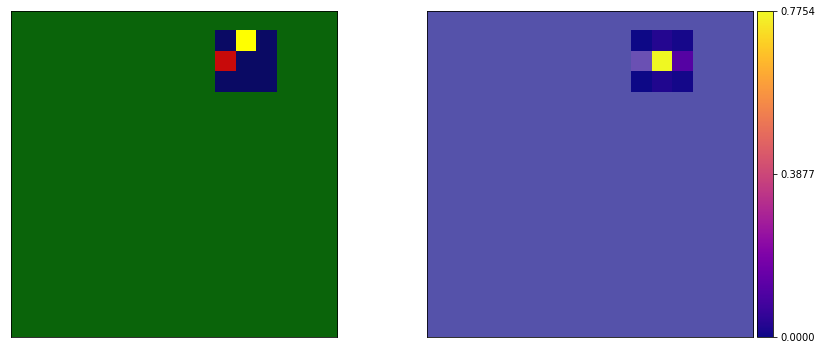


Step 11
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 99.05 - POINT: (x,y)=(11,2)
Action selected:  [2]
State value: 10.9487
Move advantage: 0.7626


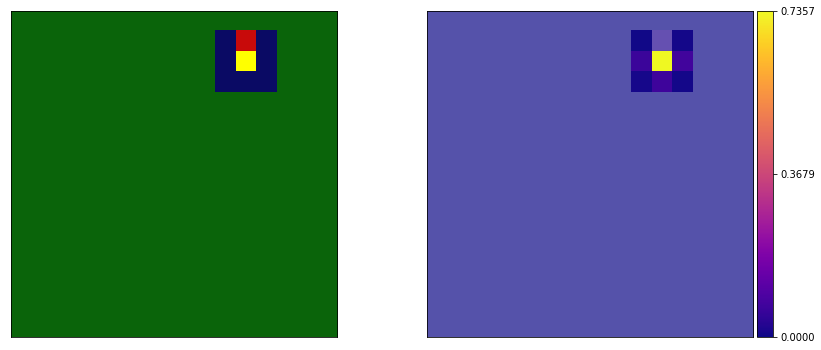


Step 12
_NO_OP: 	0.00
_SELECT_ARMY:  0.01 - _SELECT_ALL: 0.04
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.57 - POINT: (x,y)=(4,9)
Action selected:  [2]
State value: 9.9206
Move advantage: -0.0267


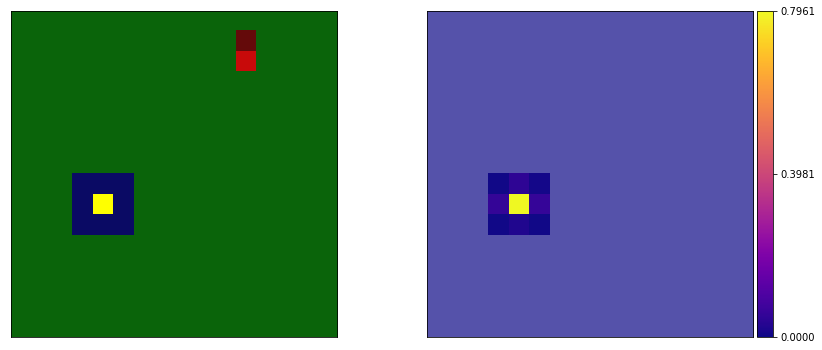


Step 13
_NO_OP: 	0.00
_SELECT_ARMY:  0.01 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.61 - POINT: (x,y)=(4,9)
Action selected:  [2]
State value: 9.9658
Move advantage: 0.0769


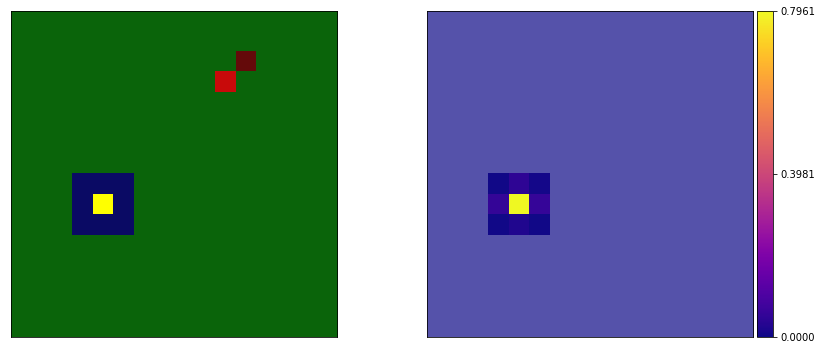


Step 14
_NO_OP: 	0.00
_SELECT_ARMY:  0.01 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.61 - POINT: (x,y)=(4,9)
Action selected:  [2]
State value: 9.9658
Move advantage: 0.2915


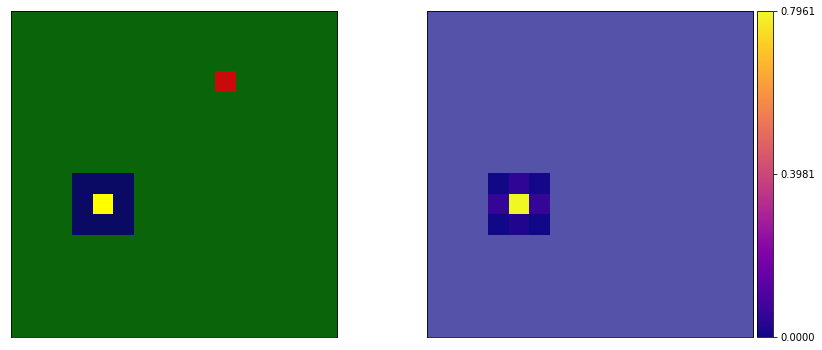


Step 15
_NO_OP: 	0.00
_SELECT_ARMY:  0.01 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.68 - POINT: (x,y)=(4,9)
Action selected:  [2]
State value: 10.1001
Move advantage: 0.2889


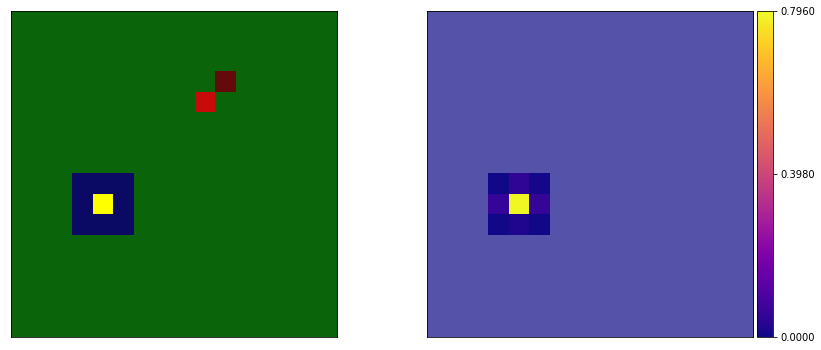


Step 16
_NO_OP: 	0.00
_SELECT_ARMY:  0.01 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.68 - POINT: (x,y)=(4,9)
Action selected:  [2]
State value: 10.1001
Move advantage: 0.2907


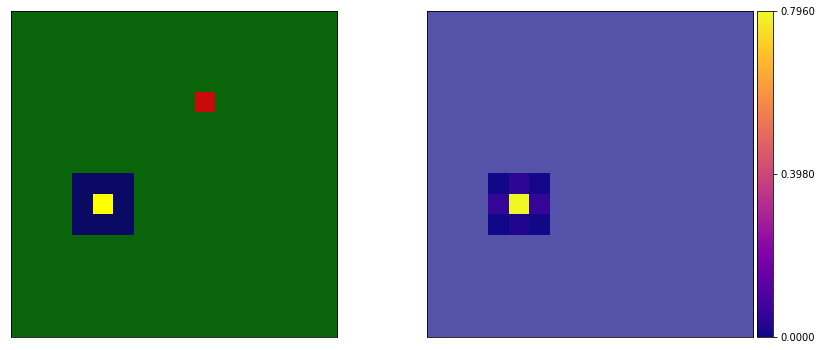


Step 17
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.80 - POINT: (x,y)=(4,9)
Action selected:  [2]
State value: 10.3179
Move advantage: 0.2464


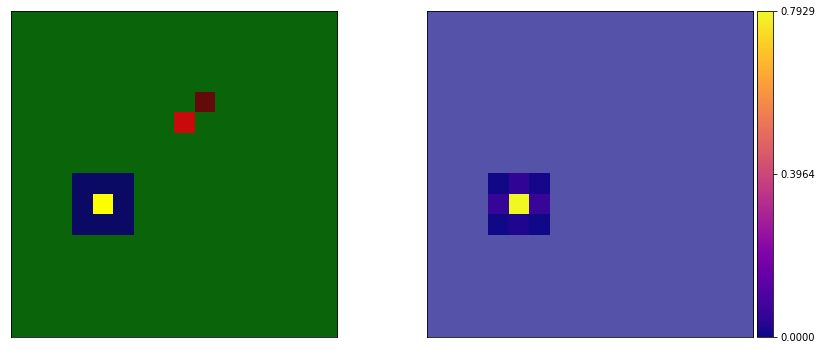


Step 18
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.80 - POINT: (x,y)=(4,9)
Action selected:  [2]
State value: 10.3179
Move advantage: 1.1815


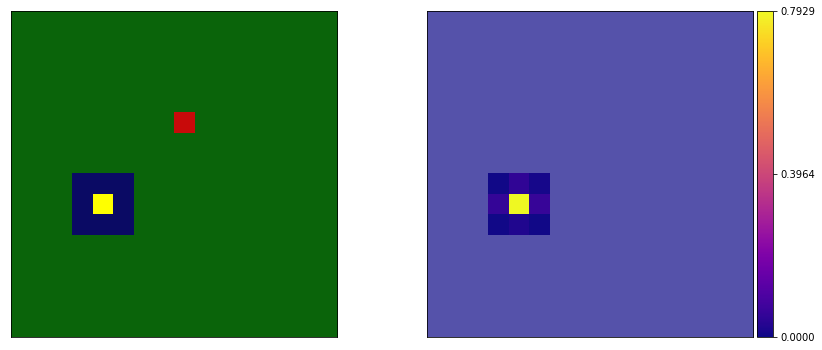


Step 19
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.90 - POINT: (x,y)=(4,9)
Action selected:  [2]
State value: 10.5223
Move advantage: 0.0828


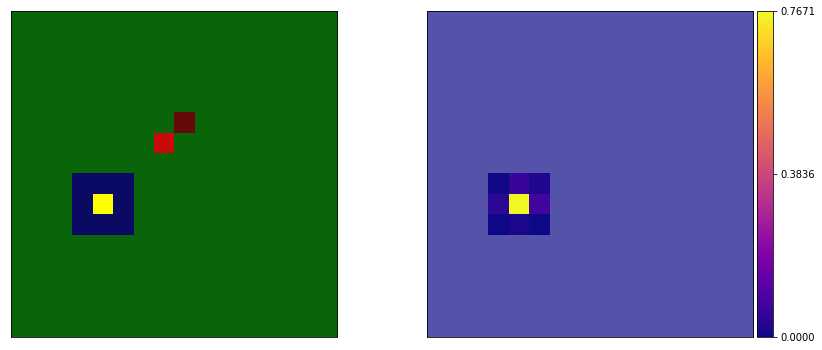


Step 20
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.90 - POINT: (x,y)=(4,9)
Action selected:  [2]
State value: 10.5223
Move advantage: 0.1352


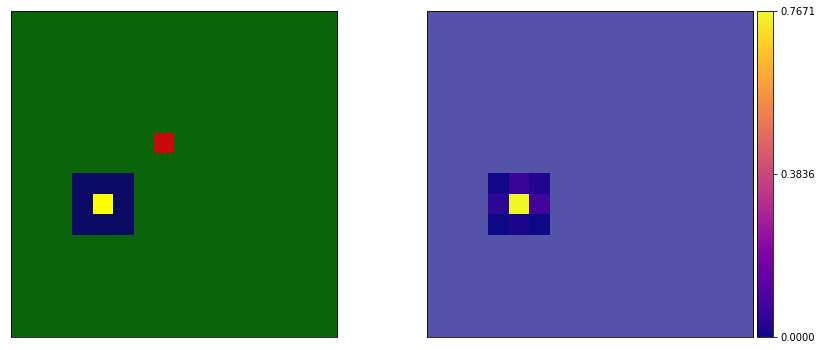


Step 21
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.97 - POINT: (x,y)=(4,9)
Action selected:  [2]
State value: 10.6871
Move advantage: 0.0305


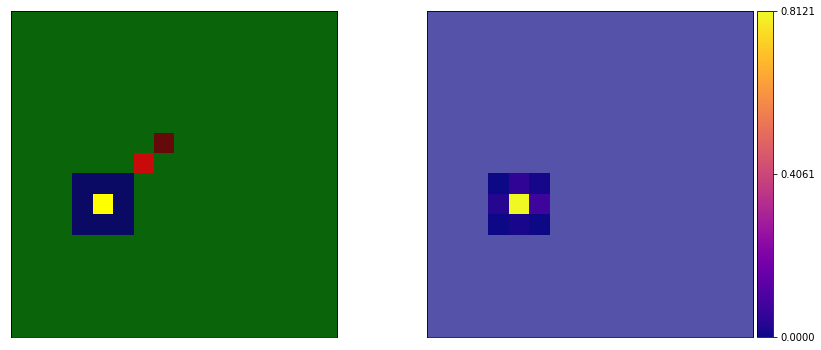


Step 22
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.97 - POINT: (x,y)=(4,9)
Action selected:  [2]
State value: 10.6871
Move advantage: 0.2362


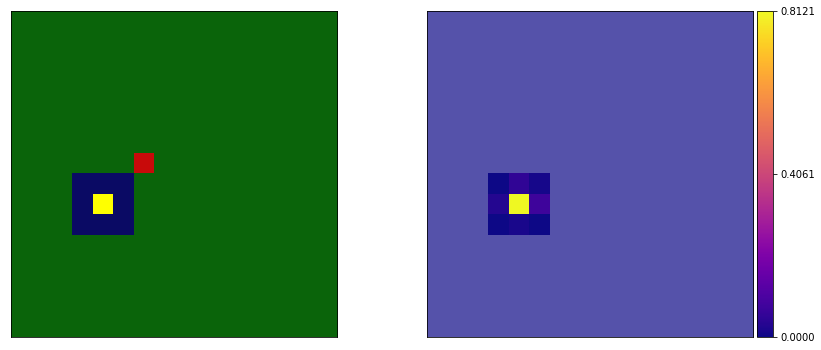


Step 23
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 99.05 - POINT: (x,y)=(3,9)
Action selected:  [2]
State value: 10.8931
Move advantage: 0.0582


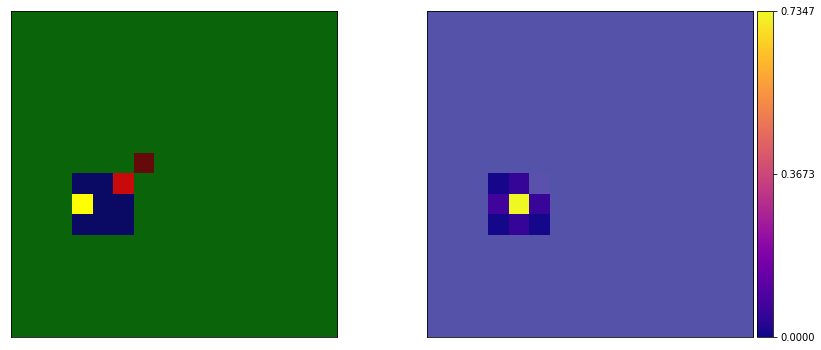


Step 24
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 99.05 - POINT: (x,y)=(4,9)
Action selected:  [2]
State value: 10.8931
Move advantage: 0.2407


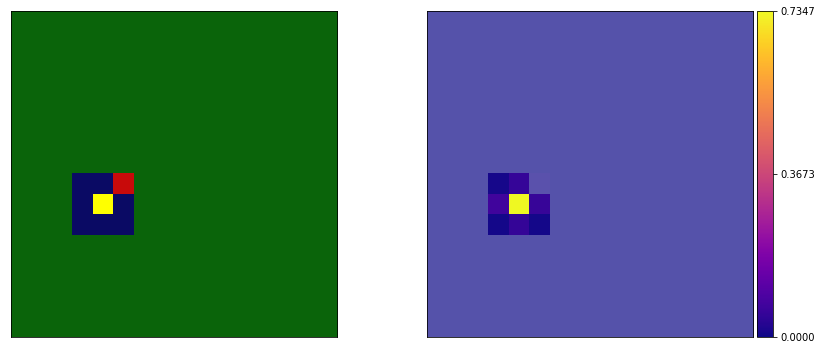


Step 25
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.74 - POINT: (x,y)=(5,4)
Action selected:  [2]
State value: 10.2536
Move advantage: 0.0643


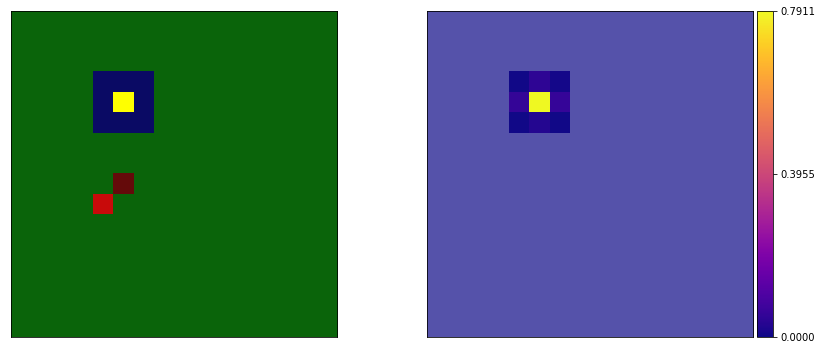


Step 26
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.84 - POINT: (x,y)=(5,4)
Action selected:  [2]
State value: 10.4480
Move advantage: -0.1116


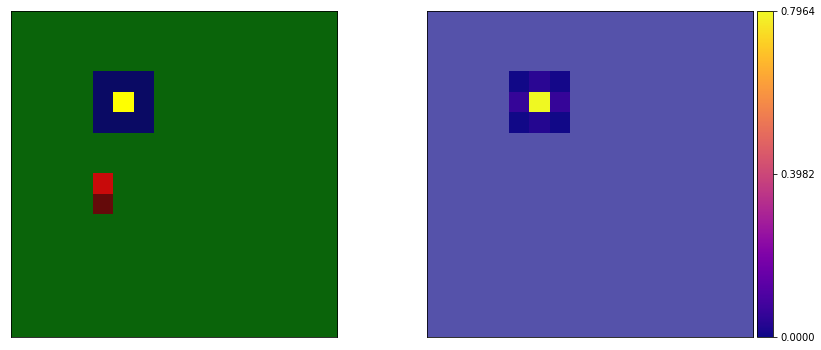


Step 27
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.94 - POINT: (x,y)=(5,4)
Action selected:  [2]
State value: 10.6611
Move advantage: -0.1624


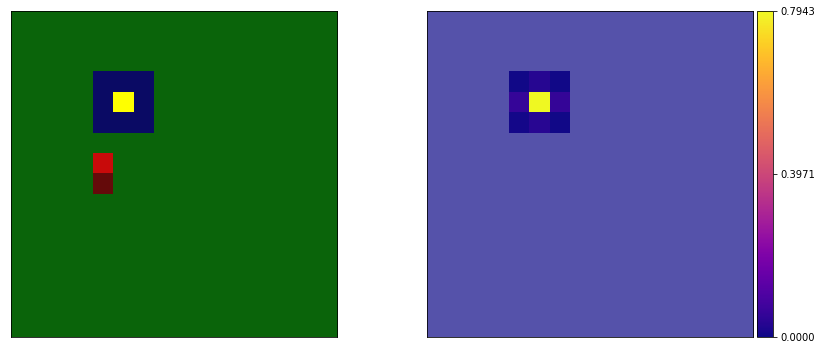


Step 28
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.96 - POINT: (x,y)=(6,4)
Action selected:  [2]
State value: 10.7130
Move advantage: -0.0174


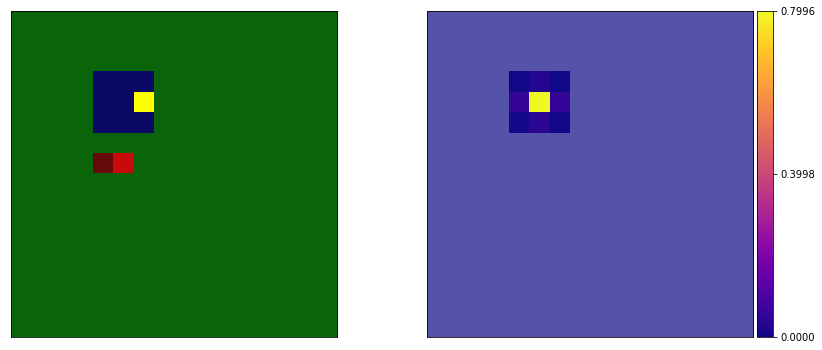


Step 29
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 99.03 - POINT: (x,y)=(5,4)
Action selected:  [2]
State value: 10.8878
Move advantage: 0.6183


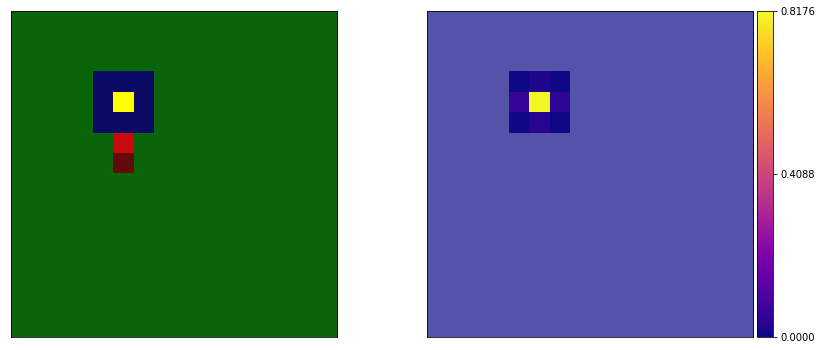


Step 30
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 99.08 - POINT: (x,y)=(5,4)
Action selected:  [2]
State value: 11.0130
Move advantage: -0.2780


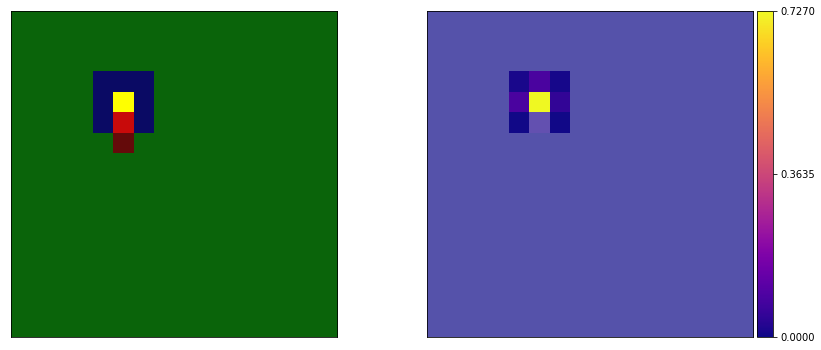


Step 31
_NO_OP: 	0.00
_SELECT_ARMY:  0.01 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.61 - POINT: (x,y)=(4,9)
Action selected:  [2]
State value: 9.9925
Move advantage: -0.2897


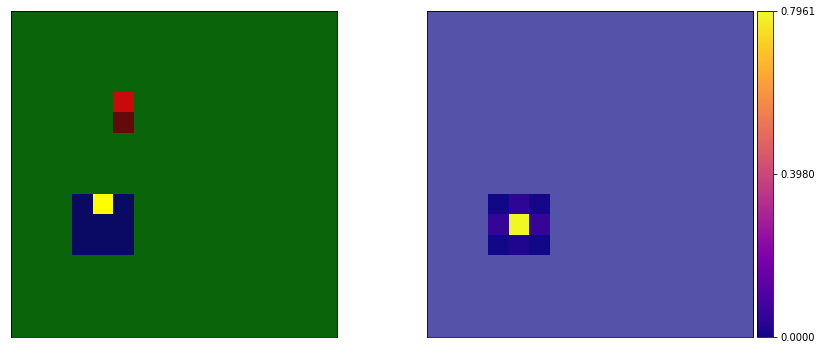


Step 32
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.70 - POINT: (x,y)=(4,10)
Action selected:  [2]
State value: 10.1533
Move advantage: -0.4903


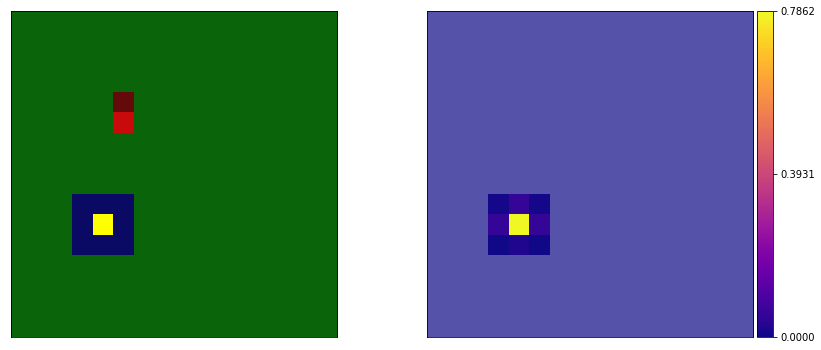


Step 33
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.83 - POINT: (x,y)=(4,10)
Action selected:  [2]
State value: 10.3942
Move advantage: -0.6518


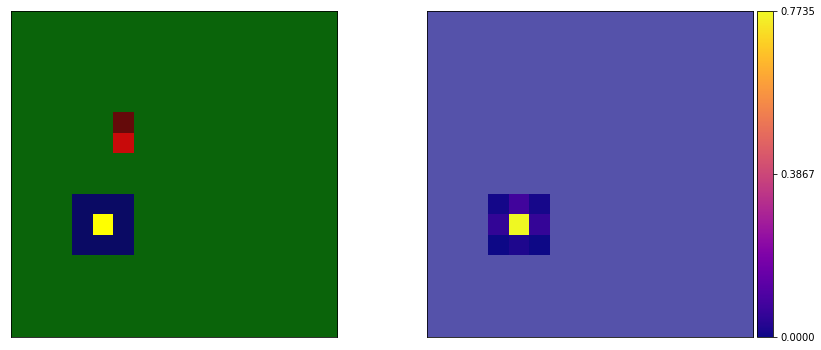


Step 34
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.89 - POINT: (x,y)=(4,10)
Action selected:  [2]
State value: 10.5334
Move advantage: -0.7162


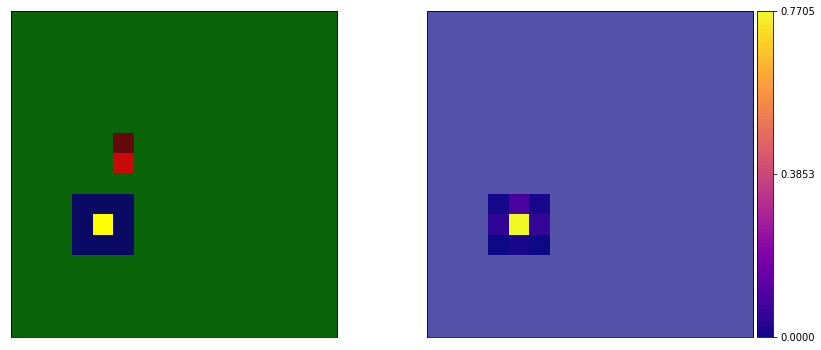


Step 35
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.88 - POINT: (x,y)=(3,10)
Action selected:  [2]
State value: 10.5137
Move advantage: -0.6542


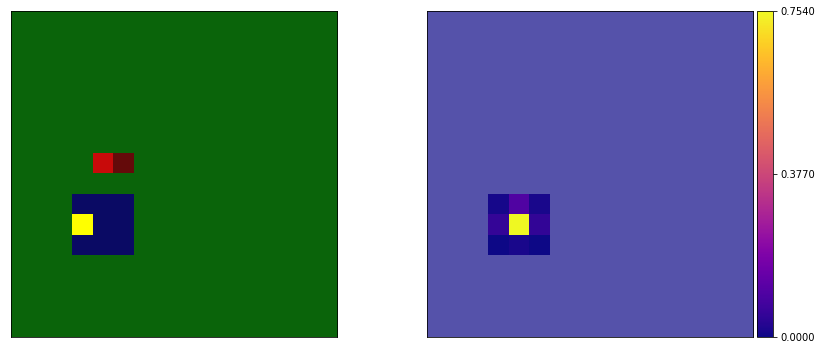


Step 36
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.97 - POINT: (x,y)=(4,9)
Action selected:  [2]
State value: 10.7037
Move advantage: -0.7467


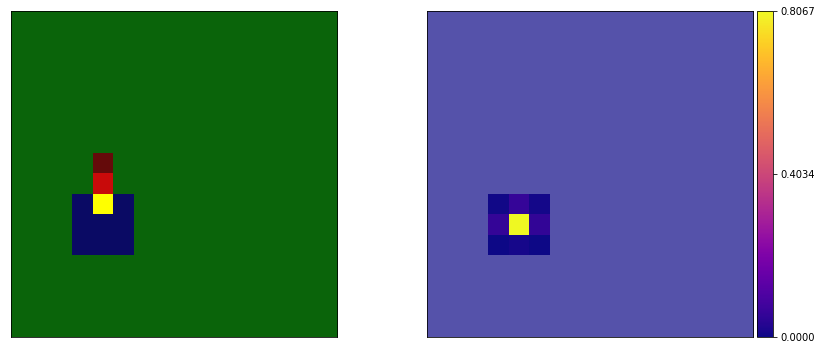


Step 37
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 99.02 - POINT: (x,y)=(4,10)
Action selected:  [2]
State value: 10.8147
Move advantage: -0.8045


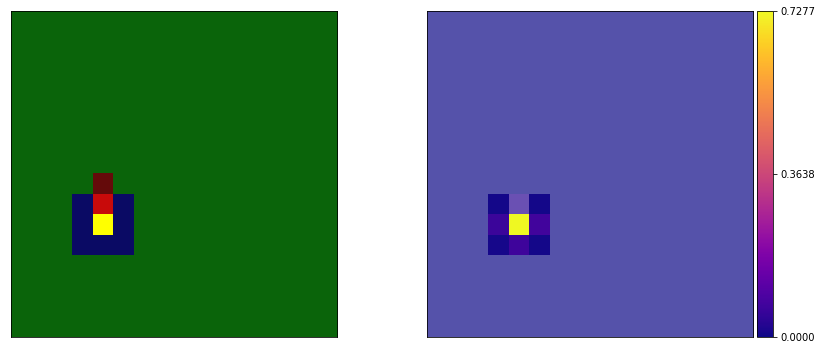


Step 38
_NO_OP: 	0.00
_SELECT_ARMY:  0.01 - _SELECT_ALL: 0.05
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.39 - POINT: (x,y)=(1,2)
Action selected:  [2]
State value: 9.6884
Move advantage: -0.6443


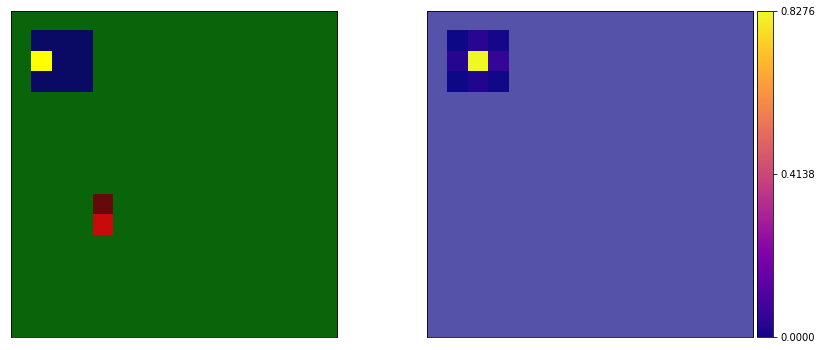


Step 39
_NO_OP: 	0.00
_SELECT_ARMY:  0.01 - _SELECT_ALL: 0.04
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.41 - POINT: (x,y)=(1,2)
Action selected:  [2]
State value: 9.7193
Move advantage: -0.6008


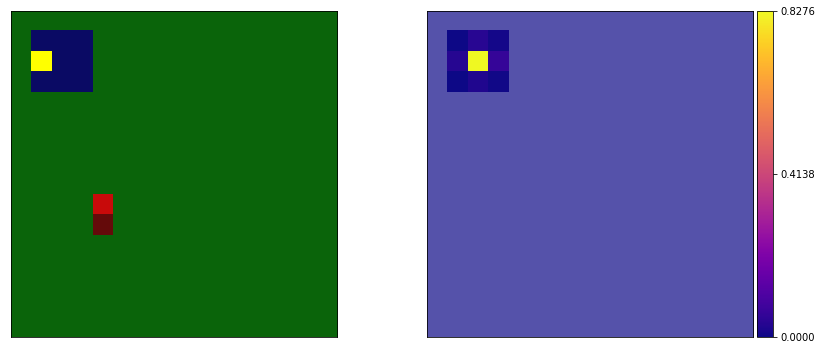


Step 40
_NO_OP: 	0.00
_SELECT_ARMY:  0.01 - _SELECT_ALL: 0.04
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.44 - POINT: (x,y)=(2,1)
Action selected:  [2]
State value: 9.7595
Move advantage: -0.5690


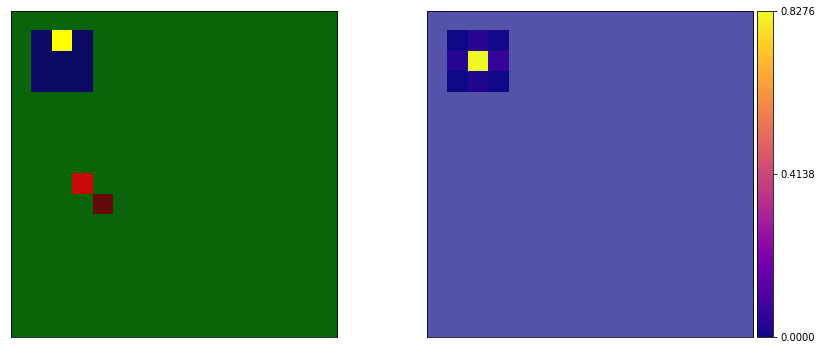


Step 41
_NO_OP: 	0.00
_SELECT_ARMY:  0.01 - _SELECT_ALL: 0.04
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.57 - POINT: (x,y)=(2,2)
Action selected:  [2]
State value: 9.9773
Move advantage: -0.7137


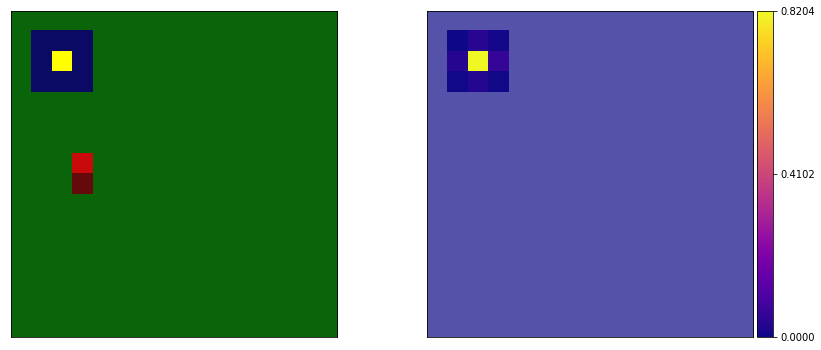


Step 42
_NO_OP: 	0.00
_SELECT_ARMY:  0.01 - _SELECT_ALL: 0.04
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.57 - POINT: (x,y)=(3,2)
Action selected:  [2]
State value: 9.9772
Move advantage: -0.6333


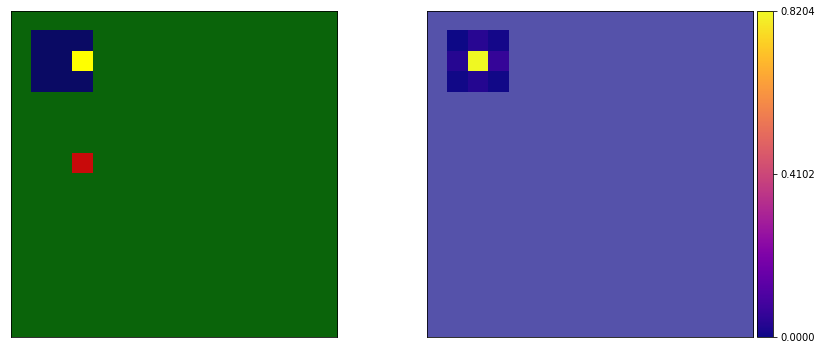


Step 43
_NO_OP: 	0.00
_SELECT_ARMY:  0.01 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.68 - POINT: (x,y)=(2,2)
Action selected:  [2]
State value: 10.1660
Move advantage: -0.7265


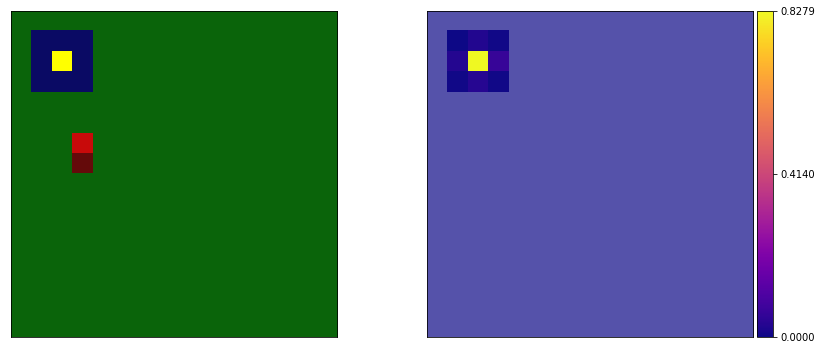


Step 44
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.79 - POINT: (x,y)=(2,2)
Action selected:  [2]
State value: 10.3685
Move advantage: -0.8525


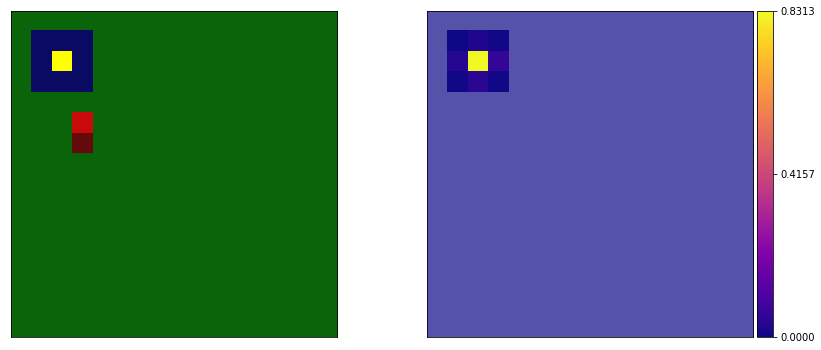


Step 45
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.03
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.79 - POINT: (x,y)=(2,2)
Action selected:  [2]
State value: 10.3685
Move advantage: -0.7610


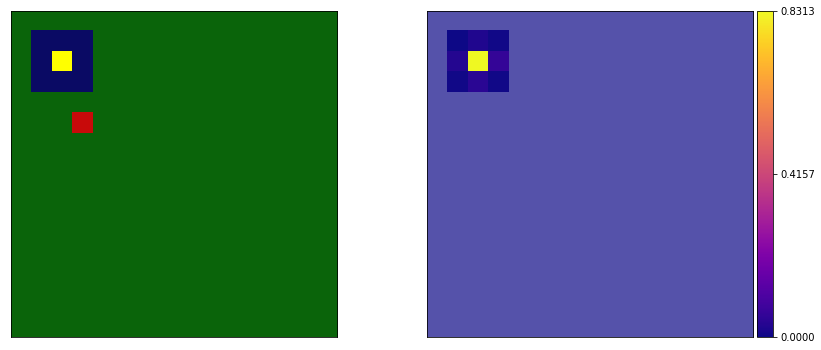


Step 46
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.87 - POINT: (x,y)=(3,2)
Action selected:  [2]
State value: 10.5440
Move advantage: -0.0541


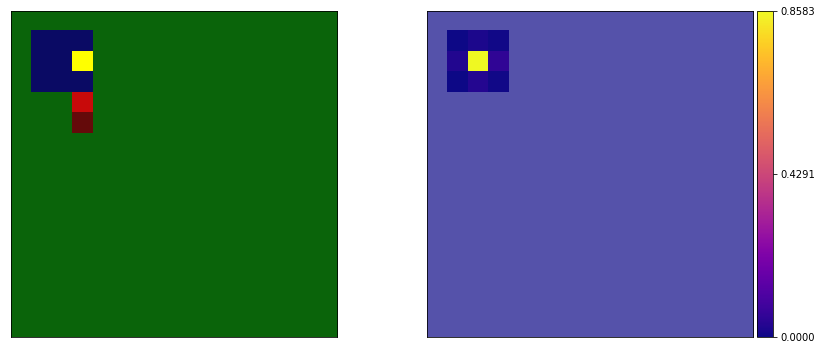


Step 47
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.97 - POINT: (x,y)=(2,2)
Action selected:  [2]
State value: 10.7616
Move advantage: -0.6974


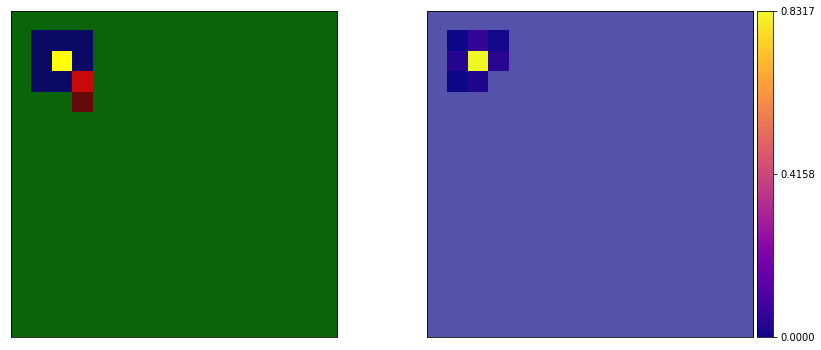


Step 48
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 0.02
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 98.95 - POINT: (x,y)=(2,2)
Action selected:  [2]
State value: 10.7190
Move advantage: -0.6713


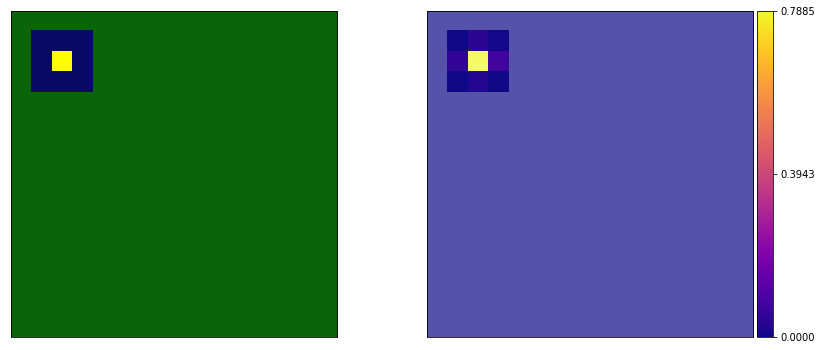


Step 49
_NO_OP: 	0.00
_SELECT_ARMY:  0.01 - _SELECT_ALL: 0.04
_MOVE_SCREEN:   99.99 - _NOT_QUEUED: 98.44 - POINT: (x,y)=(14,8)
Action selected:  [2]
State value: 9.7424
Move advantage: -0.7143


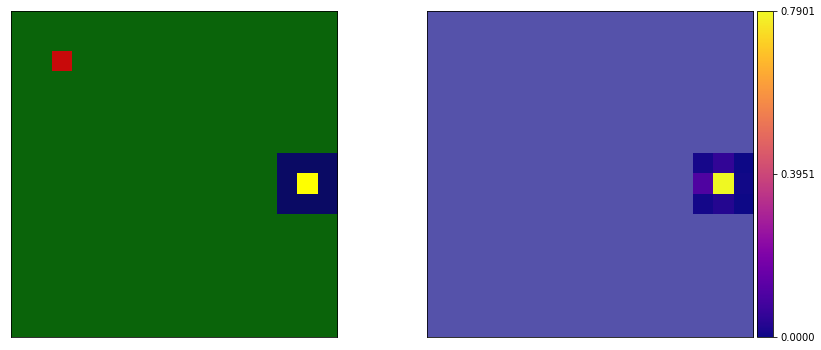

In [38]:
#for t in range(len(insp_dict['state_traj'])):
for t in range(50):
    print_action_info(insp_dict, t)
    plot_screen_and_decision(insp_dict, t)

# Value and policy evolution with training

In [38]:
load = False
if load:
    agent = torch.load("Results/MoveToBeacon/agent_"+PID, map_location='cpu')
    agent.device = 'cpu'
else: # For models not yet saved because they are still training
    RESOLUTION = 16
    MAX_STEPS = 256
    game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 
    env = init_game(game_params, max_steps=MAX_STEPS)
    model_number = 0
    model_names = {0:"FullyConvNet_v0", 1:"FullyConvNet_v1", 2:"FullyConvNet_V2", 3:"ControlNet", 4:"GatedRelationalNet"}

    if model_number == 0:
        print(model_names[model_number]+" selected.")
        spatial_model = net.FullyConvSpatial
        nonspatial_model = net.FullyConvNonSpatial
        n_channels = 32
        n_features = 256
        spatial_dict = {"in_channels":2}
        nonspatial_dict = {'resolution':RESOLUTION}

    elif model_number == 1:
        print(model_names[model_number]+" selected.")
        spatial_model = net.FullyConvSpatial_v1
        nonspatial_model = net.FullyConvNonSpatial_v1
        n_channels = 32
        n_features = 256
        spatial_dict = {"in_channels":3, 'resolution':RESOLUTION}
        nonspatial_dict = {'resolution':RESOLUTION}

    elif model_number == 2:
        print(model_names[model_number]+" selected.")
        spatial_model = net.FullyConvSpatial_v2
        nonspatial_model = net.FullyConvNonSpatial_v2
        n_channels = 32
        n_features = 256
        spatial_dict = {"in_channels":6, 'resolution':RESOLUTION}
        nonspatial_dict = {'resolution':RESOLUTION}

    elif model_number == 3:
        print(model_names[model_number]+" selected.")
        spatial_model = net.SpatialFeatures
        nonspatial_model = net.NonSpatialFeatures
        n_channels = 36
        n_features = 36
        spatial_dict = dict(n_layers=1, linear_size=RESOLUTION, in_channels=6, n_channels=n_features)
        nonspatial_dict = dict(linear_size=RESOLUTION, n_channels=n_features, pixel_hidden_dim=128, pixel_n_residuals=2, 
                     feature_hidden_dim=64, feature_n_residuals=2)
    elif model_number == 4:
        print(model_names[model_number]+" selected.")
        patial_model = net.SpatialFeatures
        nonspatial_model = net.GatedRelationalNet
        n_channels = 32
        n_features = 32
        spatial_dict = dict(n_layers=2, linear_size=RESOLUTION, in_channels=3, n_channels=n_features)

        nonspatial_dict = dict(n_kernels=n_features, n_features=n_features, n_heads=1, n_attn_modules=2, 
                         feature_hidden_dim=16, feature_n_residuals=1)

    else:
        print("Model number not available. Choose 0, 1, 2 or 3.")
        
    HPs = dict(action_space=3, gamma=0.99, n_steps=20, H=1e-3, 
           spatial_model=spatial_model, nonspatial_model=nonspatial_model,
           n_features=n_features, n_channels=n_channels, 
           spatial_dict=spatial_dict, nonspatial_dict=nonspatial_dict)

    # Load on cpu 
    HPs['device'] = 'cpu'

    lr = 7e-4
    agent = MoveToBeaconSpatialA2C(env=env, **HPs)
    agent1 = MoveToBeaconSpatialA2C(env=env, **HPs)

FullyConvNet_v0 selected.


This is showing for each position on the map that can be occupied by the agent how good that postion is, considering where the beacon is located.

In [39]:
print("PID: ", PID)
init_step = 0
step_jump = 4800
n_jumps = 15

PID:  TYLP


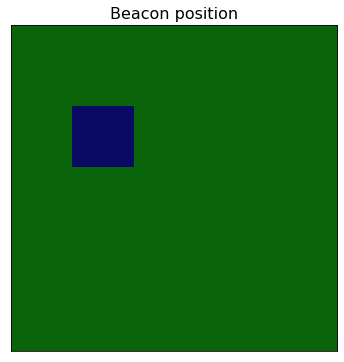

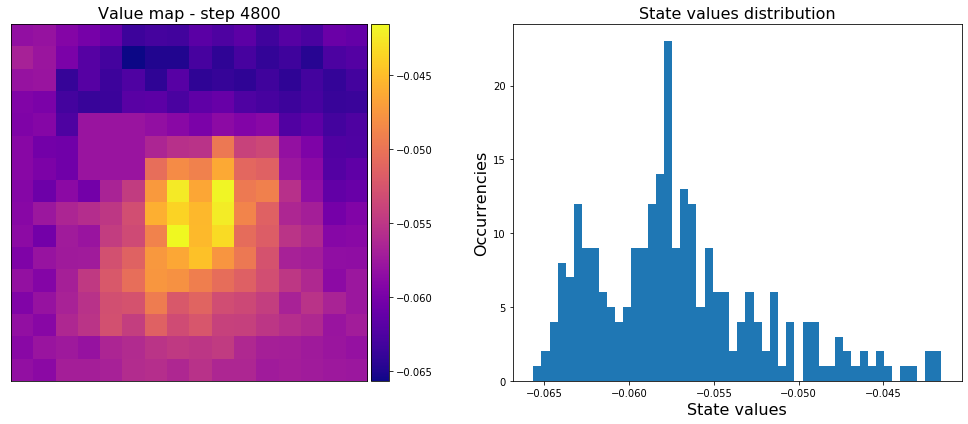

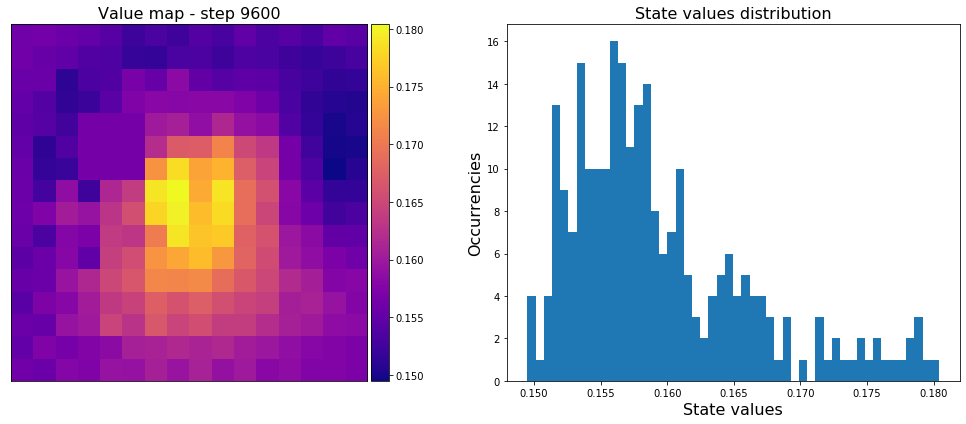

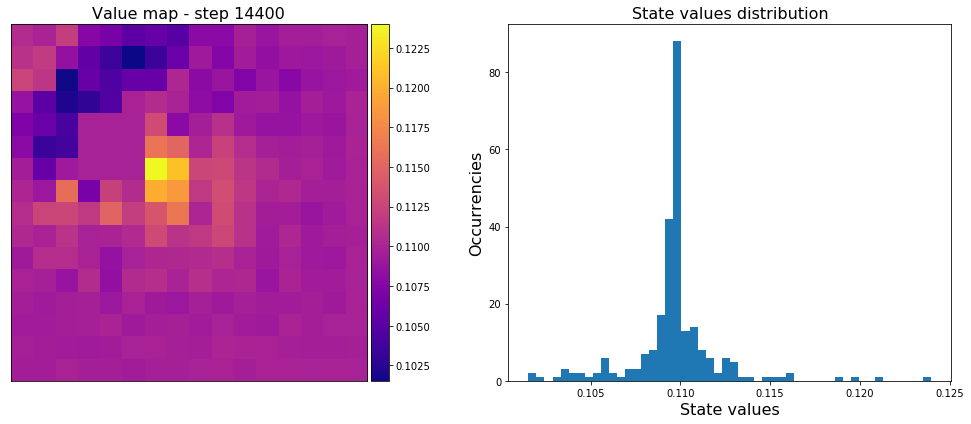

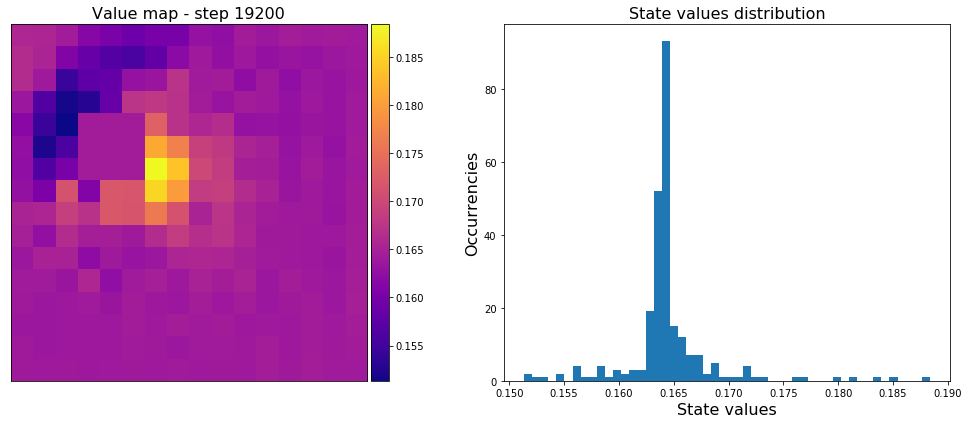

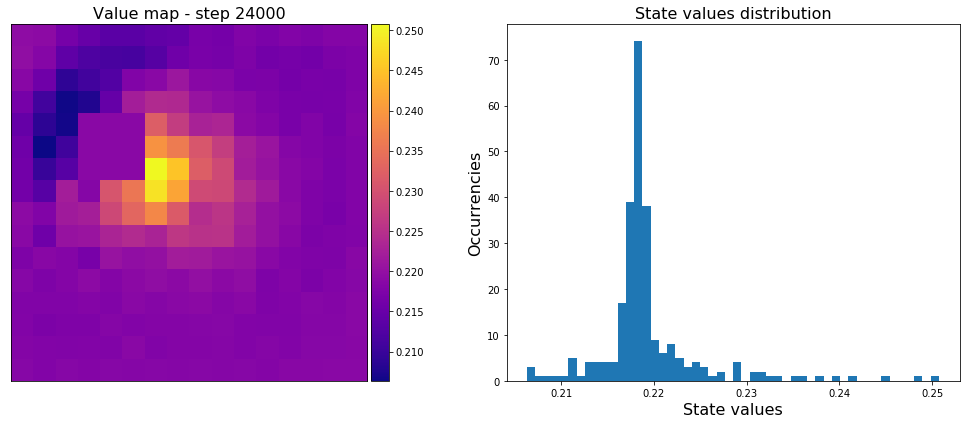

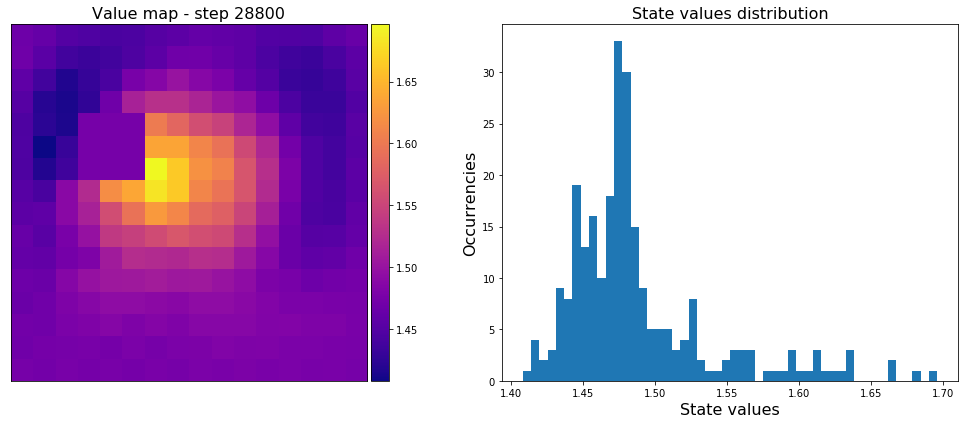

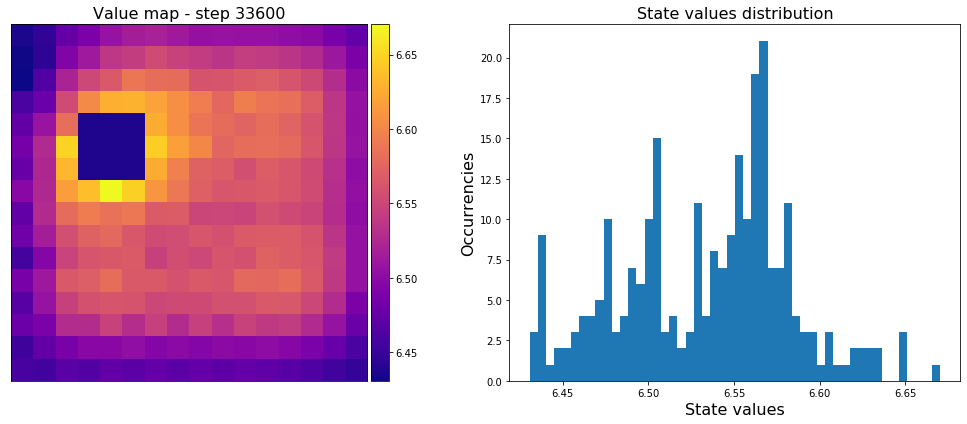

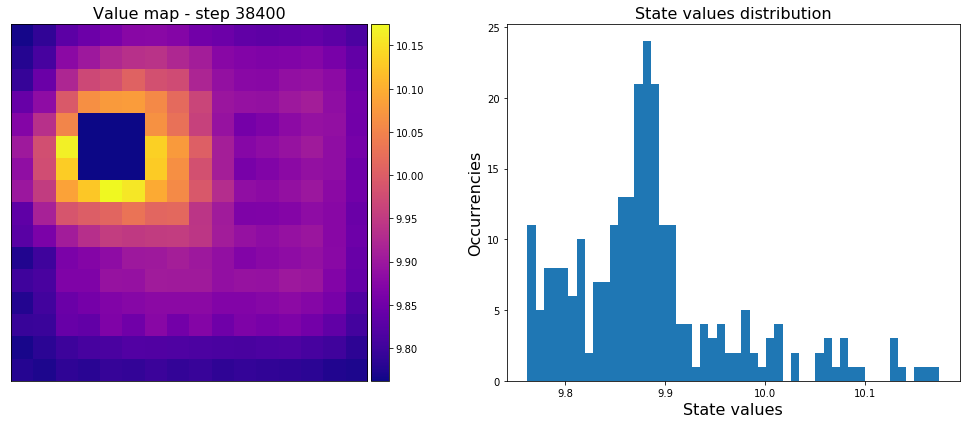

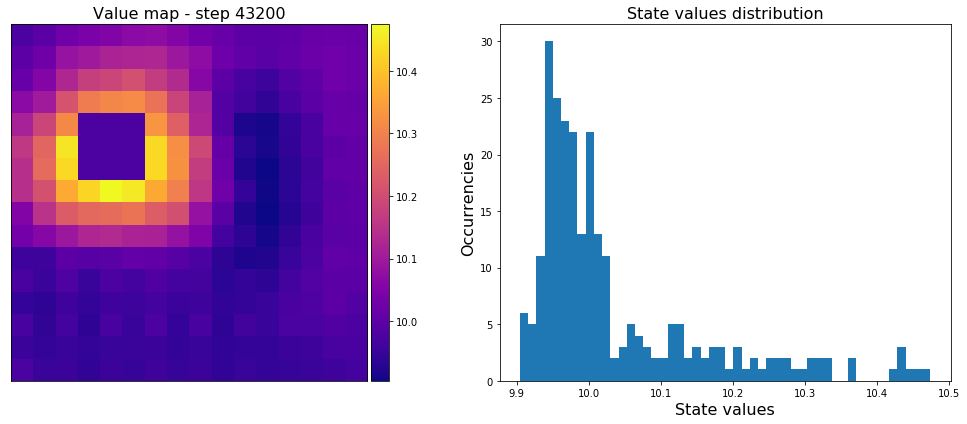

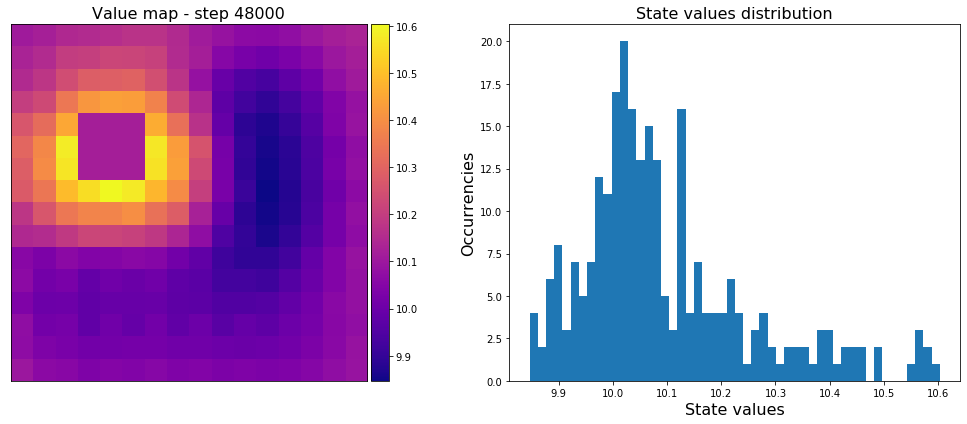

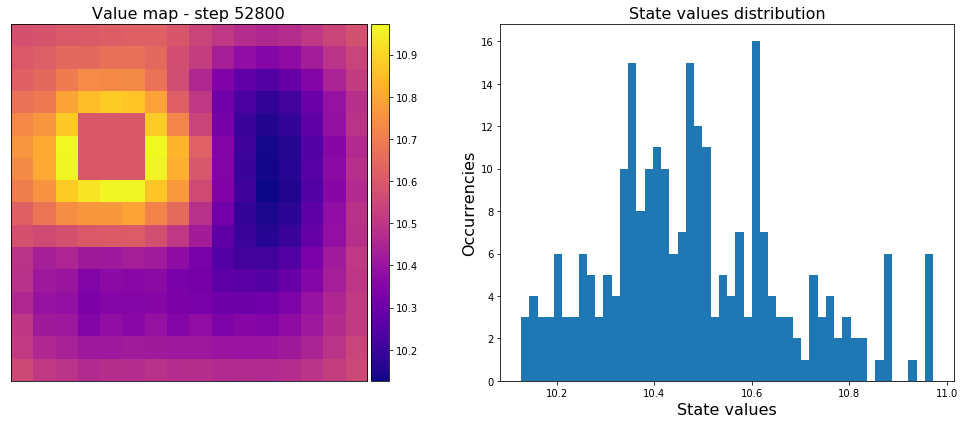

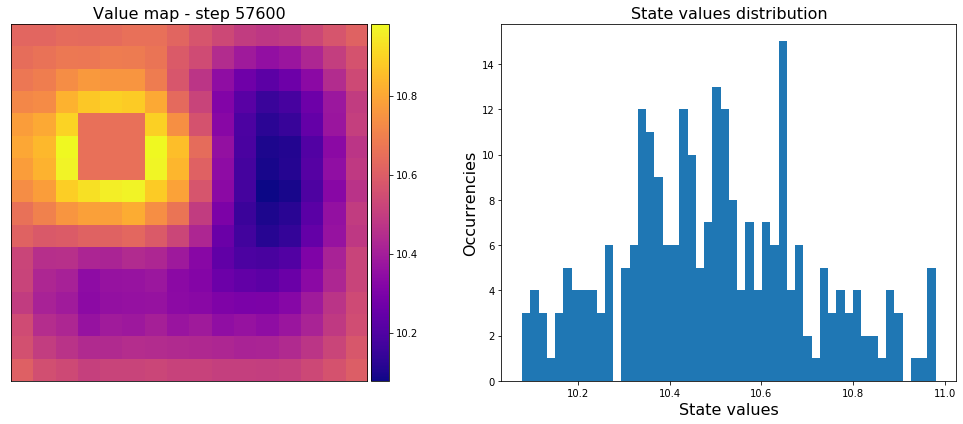

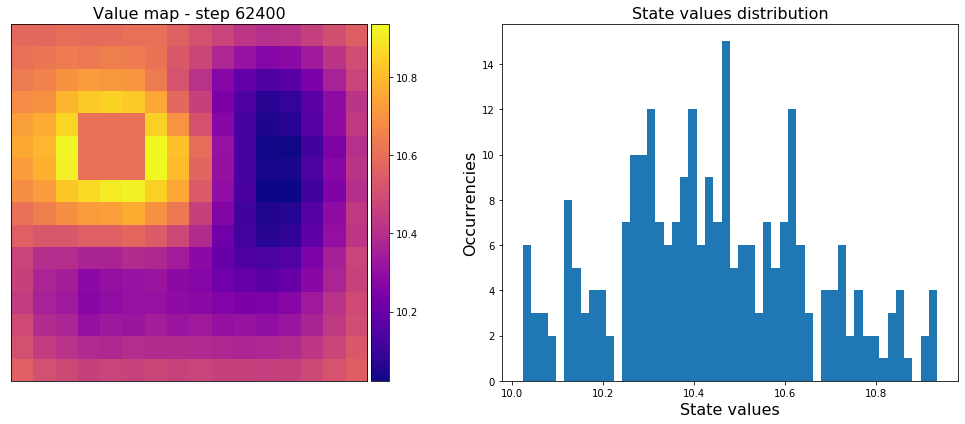

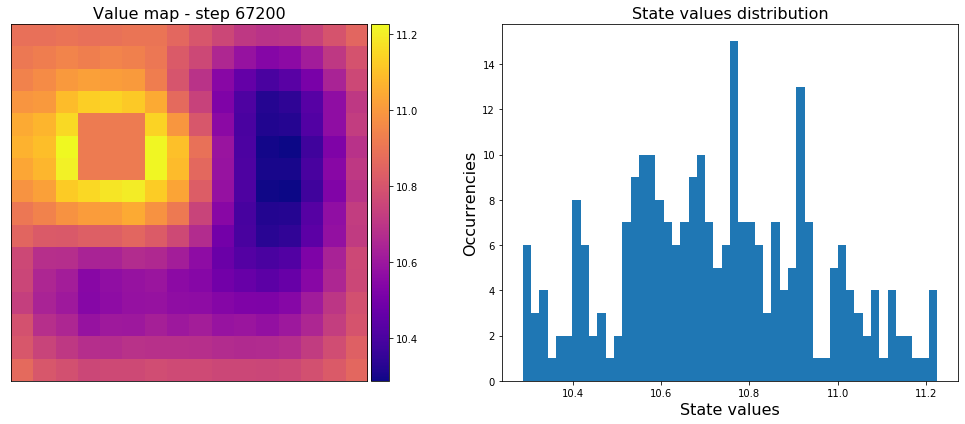

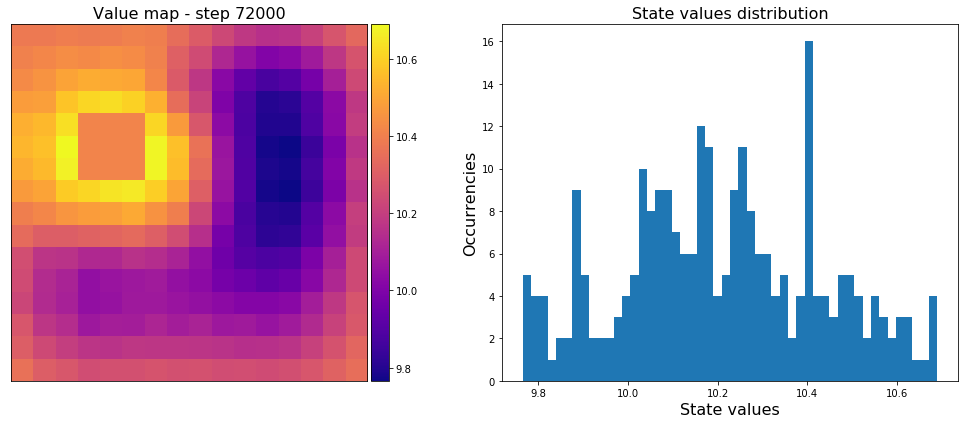

In [40]:
plot_value_maps(agent, PID, init_step, step_jump, n_jumps, beacon_pos = [4,5], n_channels=2, res=16)

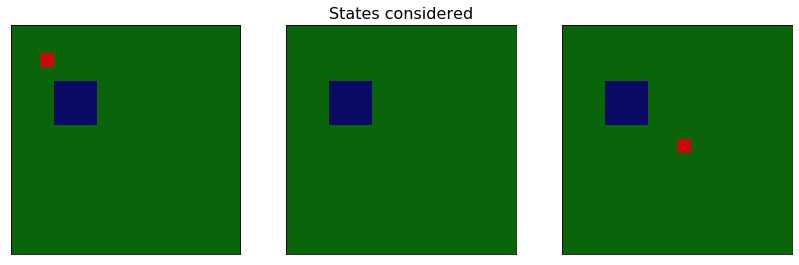

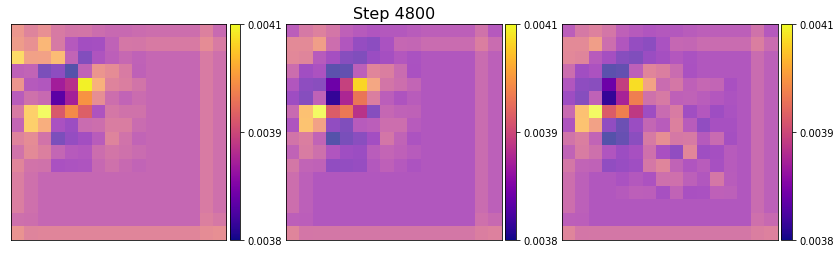

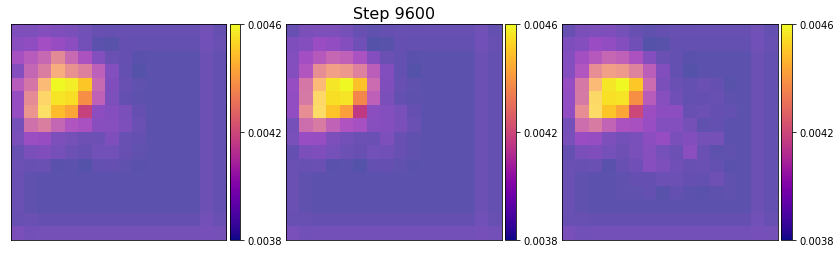

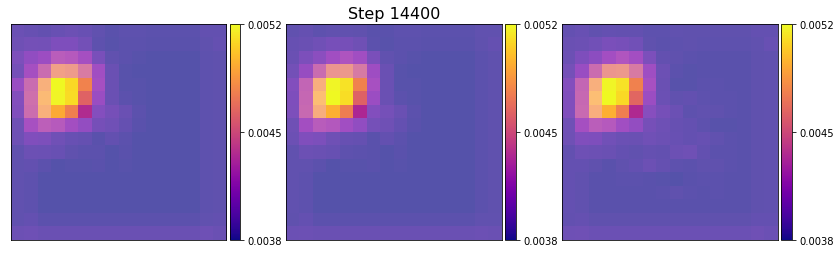

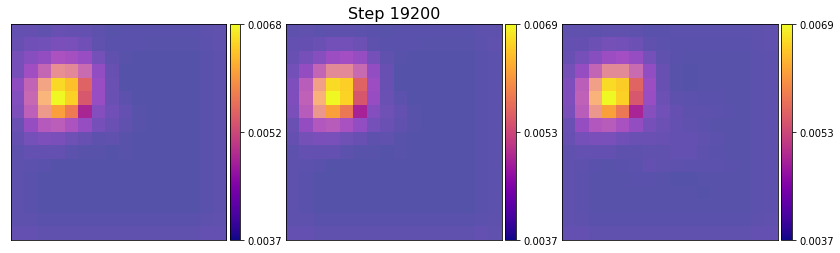

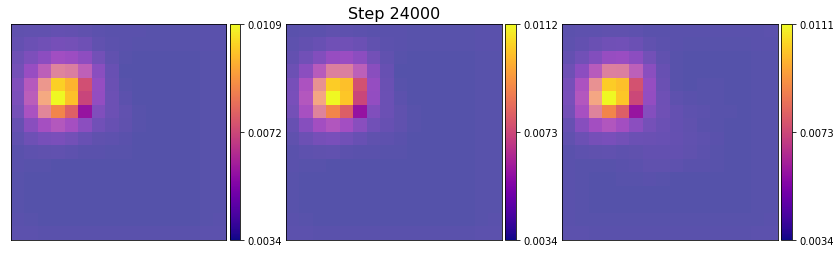

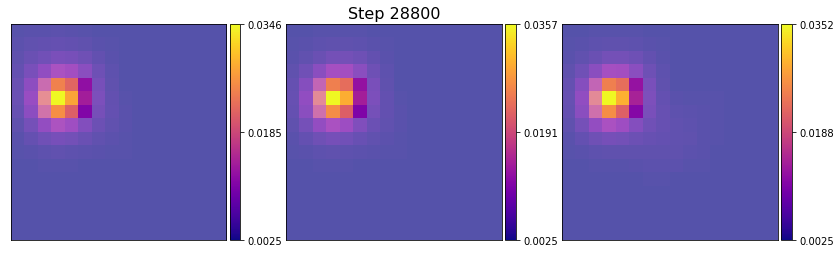

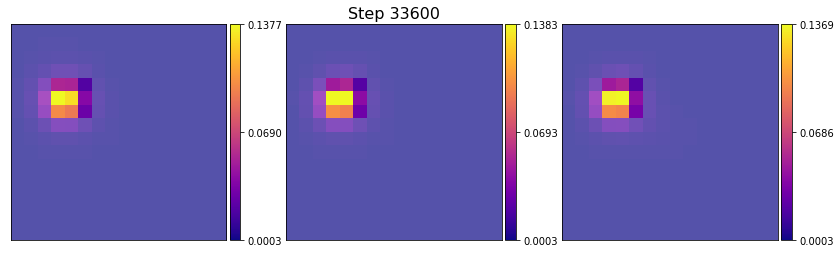

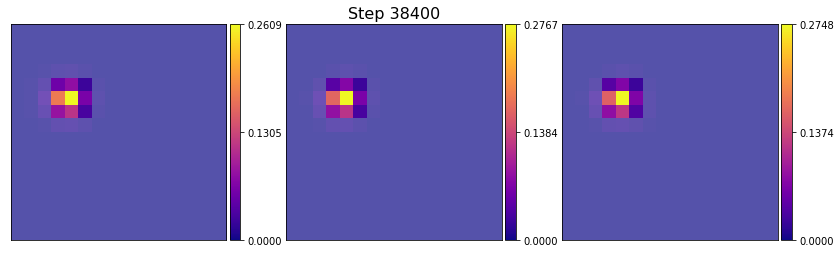

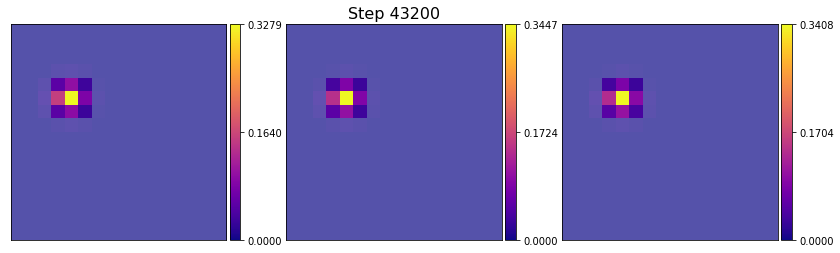

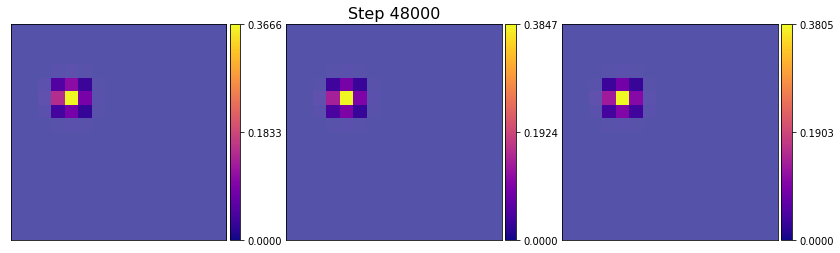

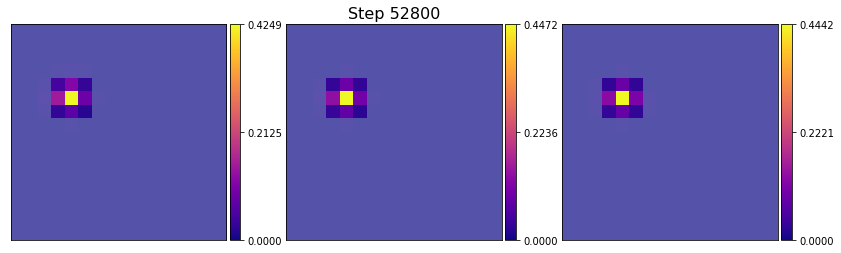

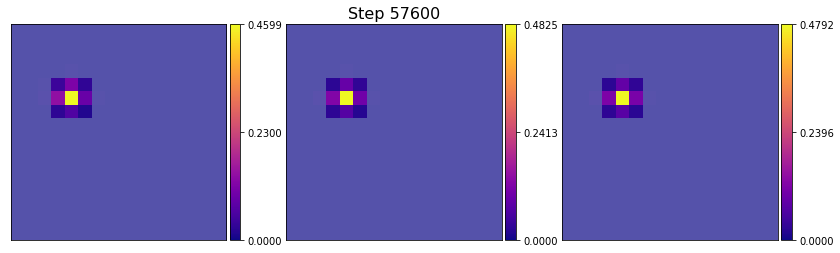

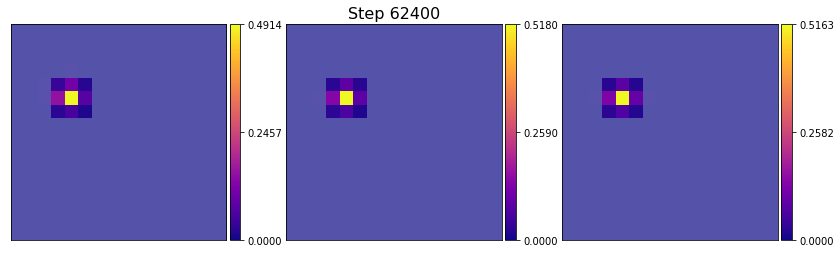

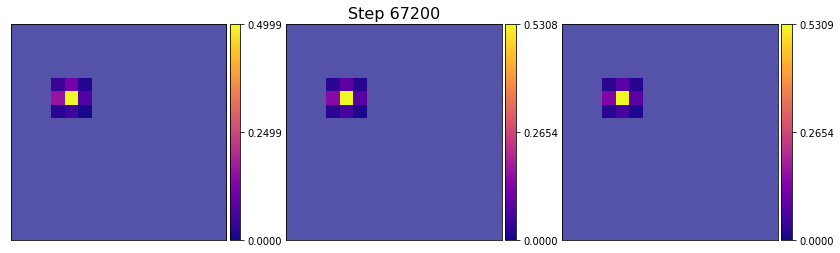

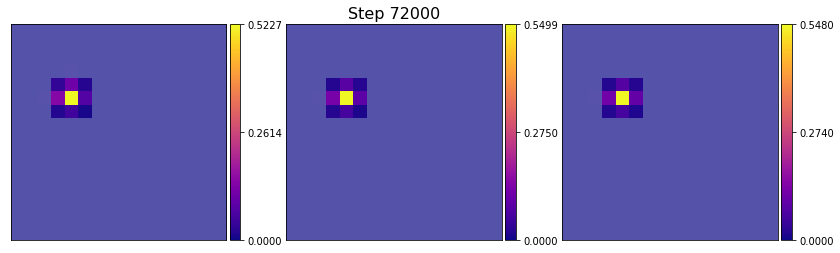

In [41]:
plot_decision_maps(agent, PID, init_step, step_jump, n_jumps, agent_pos_lst=[[2,2],[5,5],[8,8]], 
                       beacon_pos = [4,5], selected=True, n_channels=2, res=16)

# Gradient check in decision map

In [12]:
agent.AC.state_dict().keys()

odict_keys(['spatial_features_net.net.0.weight', 'spatial_features_net.net.0.bias', 'spatial_features_net.net.2.weight', 'spatial_features_net.net.2.bias', 'nonspatial_features_net.conv.0.weight', 'nonspatial_features_net.conv.0.bias', 'nonspatial_features_net.net.0.weight', 'nonspatial_features_net.net.0.bias', 'actor.linear.weight', 'actor.linear.bias', 'critic.net.weight', 'critic.net.bias', 'arguments_networks.queued.net.0.weight', 'arguments_networks.queued.net.0.bias', 'arguments_networks.queued.net.2.weight', 'arguments_networks.queued.net.2.bias', 'arguments_networks.screen.conv.0.weight', 'arguments_networks.screen.conv.0.bias', 'arguments_networks.select_add.net.0.weight', 'arguments_networks.select_add.net.0.bias', 'arguments_networks.select_add.net.2.weight', 'arguments_networks.select_add.net.2.bias'])

In [13]:
init_step = 0
step_jump = 4800
n_jumps = 5
abs_diff = []
for n in range(1,n_jumps):
    
    step_idx = init_step + step_jump*n
    agent.AC.load_state_dict(torch.load("Results/MoveToBeacon/Checkpoints/"+PID+"_"+str(step_idx)))
    agent.AC.to(agent.device) 
    
    step_idx = init_step + step_jump*(n+1)
    agent1.AC.load_state_dict(torch.load("Results/MoveToBeacon/Checkpoints/"+PID+"_"+str(step_idx)))
    agent1.AC.to(agent.device) 
    
    named_params = agent.AC.named_parameters()
    named_params1 = agent1.AC.named_parameters()
    layers = []
    mean_abs_diff = []
    for n, p in named_params:
        n1, p1 = next(named_params1)
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            d = p - p1
            d = np.abs(d.detach().numpy()).mean()
            mean_abs_diff.append(d)    
    abs_diff.append(mean_abs_diff)

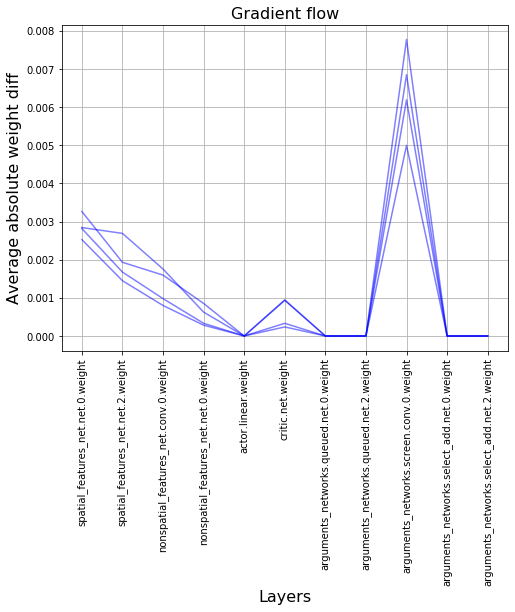

In [14]:
fig = plt.figure(figsize=(8,6))
plt.xlabel("Layers", fontsize=16)
plt.ylabel("Average absolute weight diff", fontsize=16)
plt.title("Gradient flow", fontsize=16)
for i in range(len(abs_diff)):
    plt.plot(np.arange(len(abs_diff[i])), abs_diff[i], c='b', alpha=0.5)
plt.xticks(range(0,len(abs_diff[0]), 1), layers, rotation="vertical")
plt.grid(True)
plt.show()

# Comments

Architecture analysed:
FullyConv standard, 32x32

- Spatial network: 
    - conv 5x5, padding 2, 16 kernels 
    - ReLU
    - conv 3x3, padding 1, 32 kernels
    - ReLU
- Non-Spatial network: flatten on pixel + channel dimensions (32x32x32 -> 32768) + linear layer (32768 -> 256) with ReLU

We obtain a 256-dimensional vector, used to compute the policy, value and categorical (non-spatial) parameters.
- Policy net: 256-> n_actions (3)
- Value net: 256 -> 1
- Categorical net: 256 -> 256 -> ReLU -> n_values (usually 2, for boolean flags)

To compute the spatial parameters:
- Conv2d 1x1 kernel from 32 to 1 channels (obtain 1 channel image and sample the pixel after softmax)

**Learning rate**: <br>
- $7\cdot 10^{-4}$

**n-steps used**: 
- Average from 1 to 32 steps

**Entropy regularization**:
- $10^{-3}$ for all probabilities (also those from the parameters, not just the main actions)

**Steps done**: 
- 2M+ (update here) [10h20min for 1.280M]

**Unroll length**:
-  32

**Problems**:
1. Value map is completely biased, with a baseline of 1 and an asymmetric high-value band on the lower part of the map that is completely wrong
2. Decision map is good in shape, but the values are on the wrong scale (too compressed, so that the difference between good and bad samples is shrinked)
3. The rendering made by the environment is confusing the agent, because when is near the beacon it disappears, so sometimes it learns to select it again, instead of choosing to click on the beacon
4. With the parameters that I chosen the average is ill defined, because I always consider n terms in the average, even if the timestep is less than n steps from the final state; so basically the second to last step is using once the 1-step reward and n-1 times the 2-step reward.
5. I'm still wondering how is working the movement, because the agent motion doesn't seem correlated at all with the point selected in the present or previous state.

**Update**:
1. Value map it's okay for 2 reasons:
    - The lower band is never explored and is an artifact of perspective. Maybe more layers would help in understanding that
    - The value is higher than a single reward because the episode continues even after, so the value is estimating the infinite discounted return that an agent given the current policy and the discount factor would achive.
2. Confirmed the compression of values, looks like a lack of expressional power of the architecture
3. At the same time it is also true that an episode never starts with the agent superimposed on the beacon, so the agent is in the beacon cells only when is already selected and thus the optimal action if the agent is not visible is always to click at the center of the beacon.
4. Still to fix
5. Perspective and action queueing are making everything more difficult to understand

**Obs**:
- double layer in the SpatialParameters network is able to map to 0 all pixels of the map and to non-zero just those that are not visible/accessible.
- This means that somehow there is no signal flowing backwards from the reward; Strangely it started doing like that from the very beginning... 

# Double check on trajectory saving and visualization

In [4]:
load = False
if load:
    agent = torch.load("Results/MoveToBeacon/agent_"+PID, map_location='cpu')
    agent.device = 'cpu'
else: # For models not yet saved because they are still training
    RESOLUTION = 32
    MAX_STEPS = 256
    game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 
    env = init_game(game_params, max_steps=MAX_STEPS)
    model_number = 0
    model_names = {0:"FullyConvNet_v0", 1:"FullyConvNet_v1", 2:"FullyConvNet_V2", 3:"ControlNet", 4:"GatedRelationalNet"}

    if model_number == 0:
        print(model_names[model_number]+" selected.")
        spatial_model = net.FullyConvSpatial
        nonspatial_model = net.FullyConvNonSpatial
        n_channels = 32
        n_features = 256
        spatial_dict = {"in_channels":6}
        nonspatial_dict = {'resolution':RESOLUTION}

    elif model_number == 1:
        print(model_names[model_number]+" selected.")
        spatial_model = net.FullyConvSpatial_v1
        nonspatial_model = net.FullyConvNonSpatial_v1
        n_channels = 32
        n_features = 256
        spatial_dict = {"in_channels":3, 'resolution':RESOLUTION}
        nonspatial_dict = {'resolution':RESOLUTION}

    elif model_number == 2:
        print(model_names[model_number]+" selected.")
        spatial_model = net.FullyConvSpatial_v2
        nonspatial_model = net.FullyConvNonSpatial_v2
        n_channels = 32
        n_features = 256
        spatial_dict = {"in_channels":6, 'resolution':RESOLUTION}
        nonspatial_dict = {'resolution':RESOLUTION}

    elif model_number == 3:
        print(model_names[model_number]+" selected.")
        spatial_model = net.SpatialFeatures
        nonspatial_model = net.NonSpatialFeatures
        n_channels = 36
        n_features = 36
        spatial_dict = dict(n_layers=1, linear_size=RESOLUTION, in_channels=6, n_channels=n_features)
        nonspatial_dict = dict(linear_size=RESOLUTION, n_channels=n_features, pixel_hidden_dim=128, pixel_n_residuals=2, 
                     feature_hidden_dim=64, feature_n_residuals=2)
    elif model_number == 4:
        print(model_names[model_number]+" selected.")
        patial_model = net.SpatialFeatures
        nonspatial_model = net.GatedRelationalNet
        n_channels = 32
        n_features = 32
        spatial_dict = dict(n_layers=2, linear_size=RESOLUTION, in_channels=3, n_channels=n_features)

        nonspatial_dict = dict(n_kernels=n_features, n_features=n_features, n_heads=1, n_attn_modules=2, 
                         feature_hidden_dim=16, feature_n_residuals=1)

    else:
        print("Model number not available. Choose 0, 1, 2 or 3.")
        
    HPs = dict(action_space=3, gamma=0.99, n_steps=5, H=1e-2, 
           spatial_model=spatial_model, nonspatial_model=nonspatial_model,
           n_features=n_features, n_channels=n_channels, 
           spatial_dict=spatial_dict, nonspatial_dict=nonspatial_dict)

    # Load on cpu 
    HPs['device'] = 'cpu'

    lr = 5e-5
    agent = MoveToBeaconSpatialA2C(env=env, **HPs)

FullyConvNet_v0 selected.


In [5]:
step_idx = 1200
RESOLUTION = 32
MAX_STEPS = 256
game_params = dict(feature_screen=RESOLUTION, feature_minimap=RESOLUTION, action_space="FEATURES") 
test_env = init_game(game_params, max_steps=MAX_STEPS)

In [6]:
G, insp = inspection_test(step_idx, agent, test_env, PID)

240
240


In [7]:
insp_dict = insp.dict


Step 0
_NO_OP: 	0.00
_SELECT_ARMY:  100.00 - _SELECT_ALL: 48.15
_MOVE_SCREEN:   0.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(0,0)
Action selected:  [1]
Move advantage: 0.0050


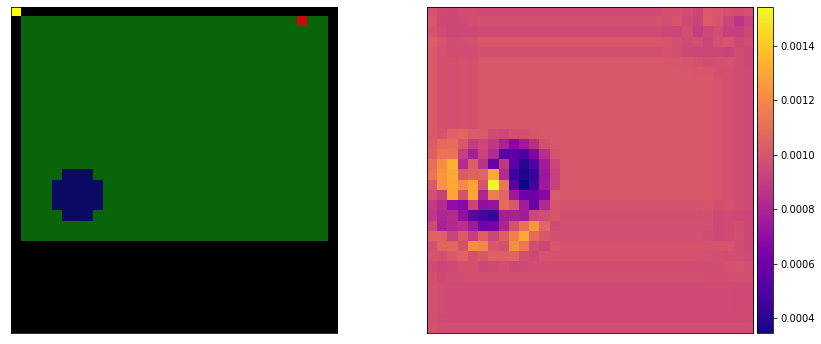


Step 1
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.57
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(2,29)
Action selected:  [2]
Move advantage: 0.0020


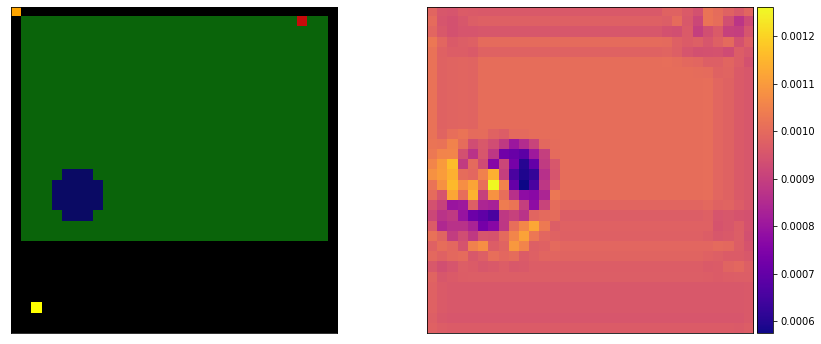


Step 2
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.61
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(19,18)
Action selected:  [2]
Move advantage: 0.0012


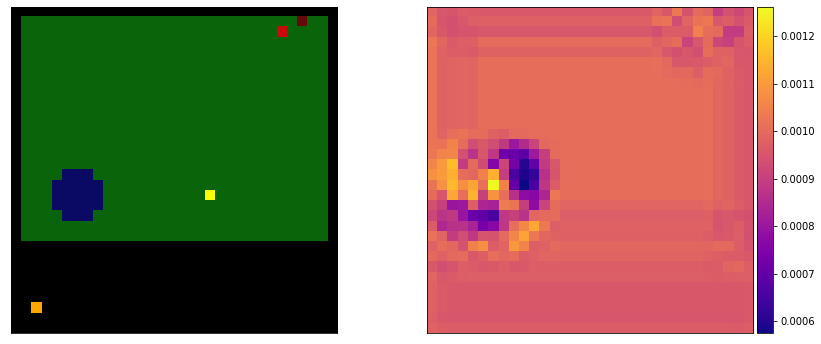


Step 3
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.59
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(17,6)
Action selected:  [2]
Move advantage: 0.0009


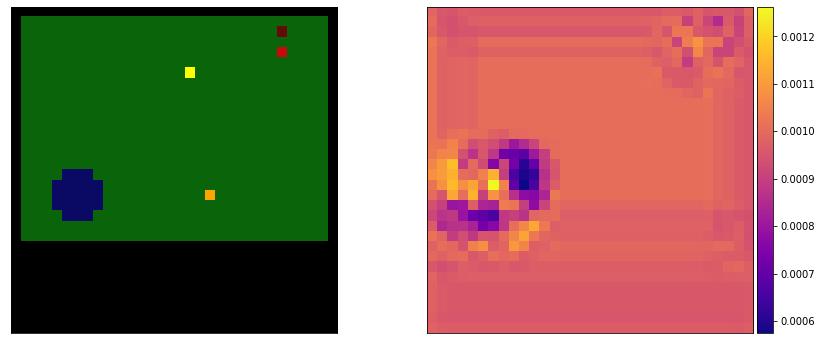


Step 4
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.59
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(5,27)
Action selected:  [2]
Move advantage: -0.0007


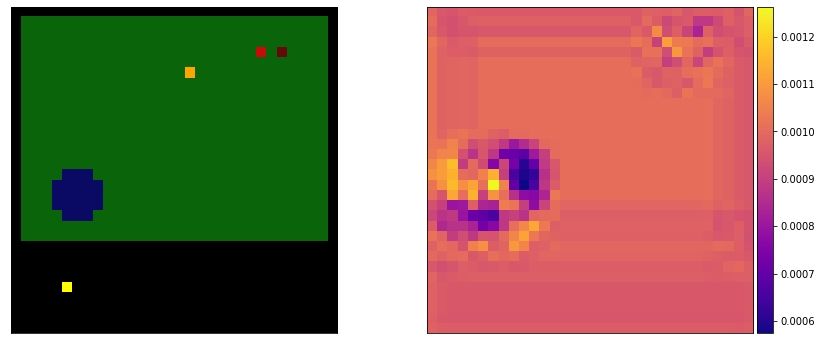


Step 5
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.66
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(30,5)
Action selected:  [2]
Move advantage: 0.0005


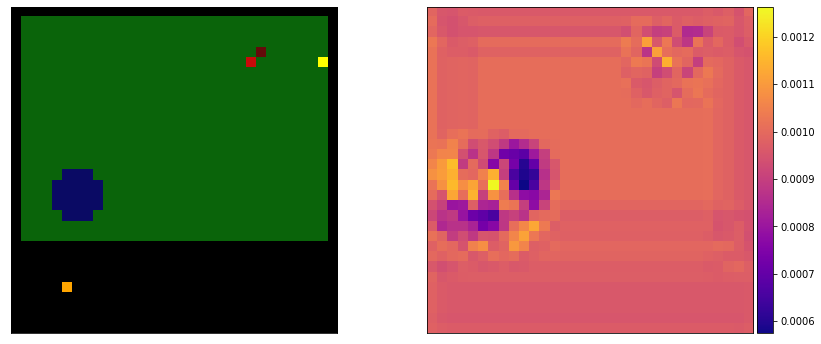


Step 6
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.59
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(10,26)
Action selected:  [2]
Move advantage: 0.0003


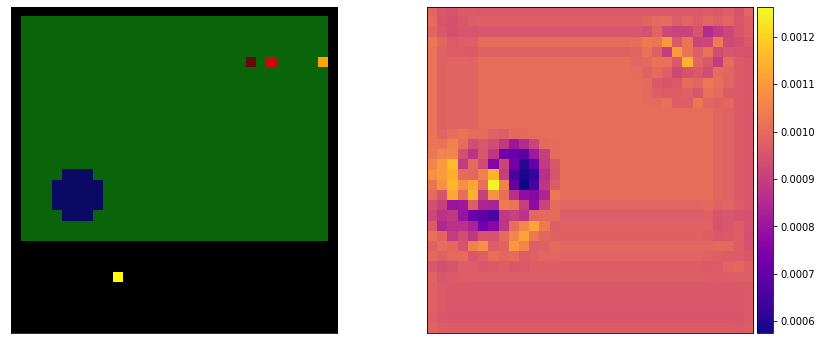


Step 7
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.60
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(0,16)
Action selected:  [2]
Move advantage: 0.0015


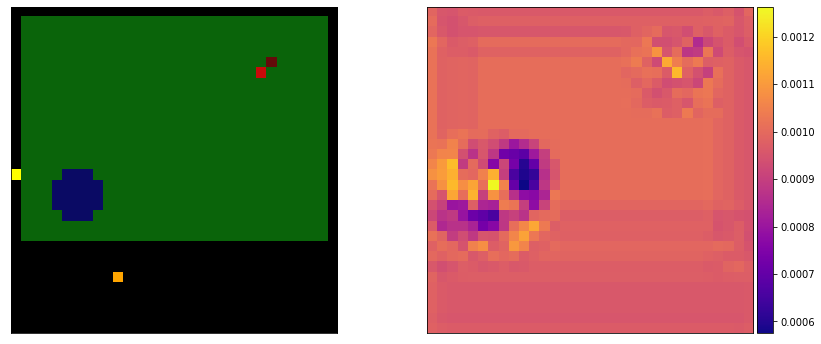


Step 8
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.61
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(20,26)
Action selected:  [2]
Move advantage: 0.0021


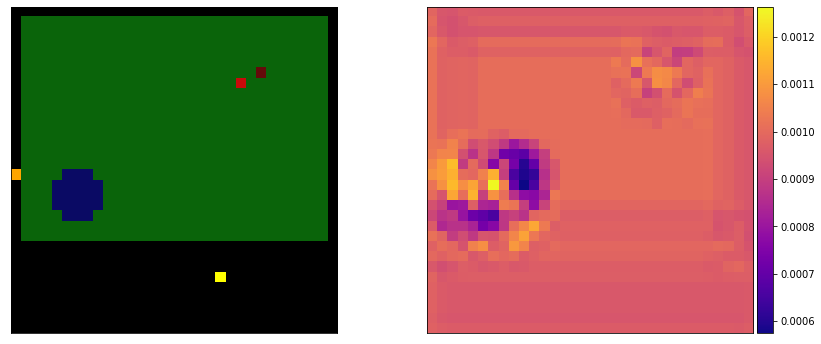


Step 9
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.53
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(10,3)
Action selected:  [2]
Move advantage: 0.0010


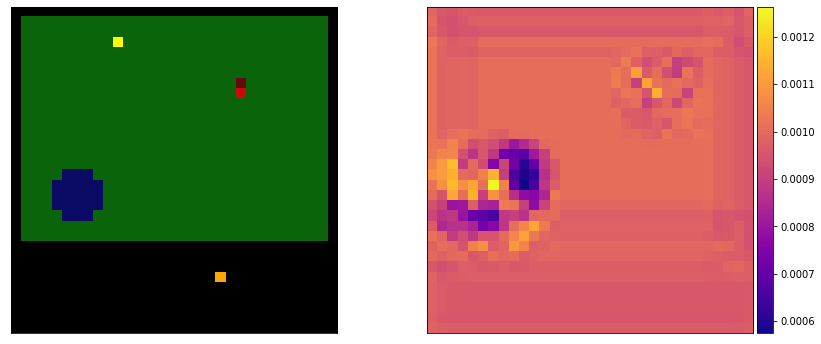


Step 10
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.55
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(2,27)
Action selected:  [2]
Move advantage: 0.0008


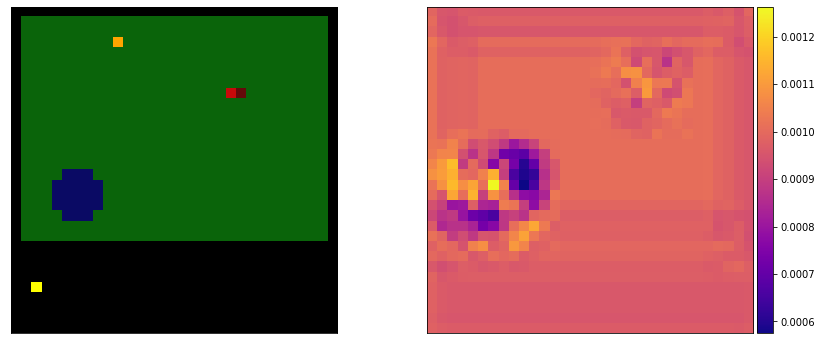


Step 11
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.55
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(27,31)
Action selected:  [2]
Move advantage: 0.0005


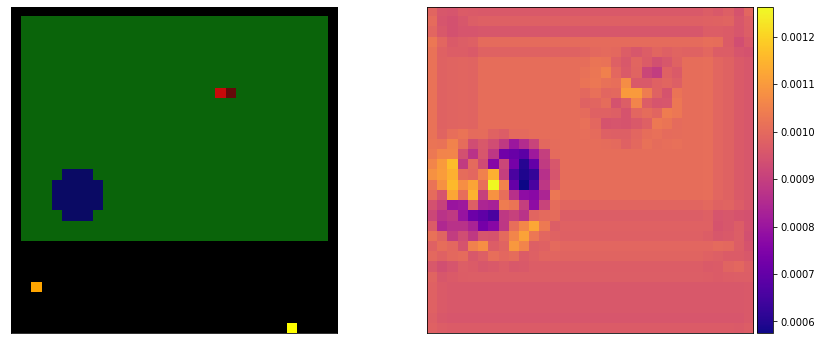


Step 12
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.57
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(6,31)
Action selected:  [2]
Move advantage: 0.0007


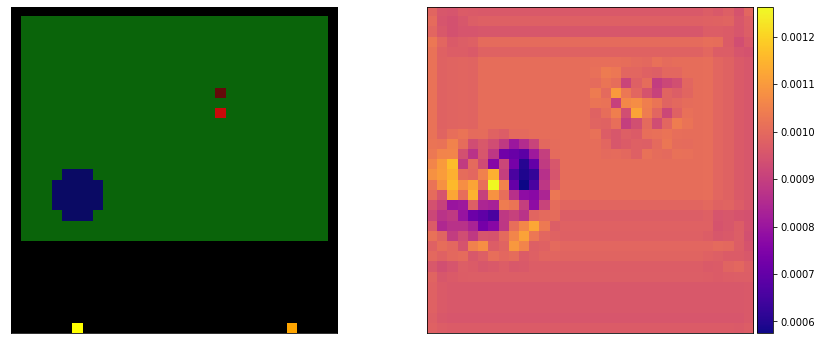


Step 13
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.61
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(23,9)
Action selected:  [2]
Move advantage: 0.0008


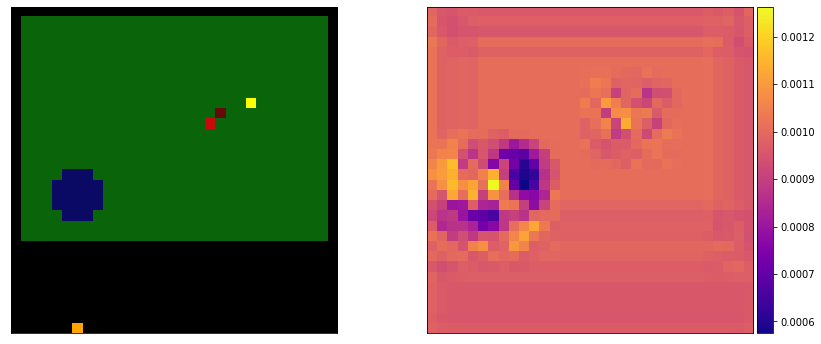


Step 14
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.57
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(27,21)
Action selected:  [2]
Move advantage: 0.0004


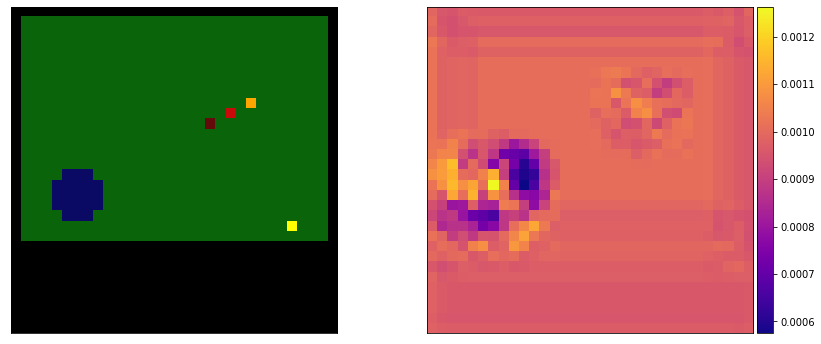


Step 15
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.61
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(17,8)
Action selected:  [2]
Move advantage: 0.0008


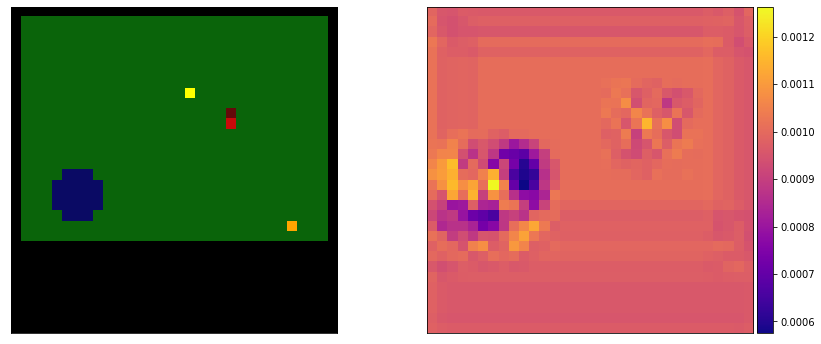


Step 16
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.61
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(23,22)
Action selected:  [2]
Move advantage: 0.0014


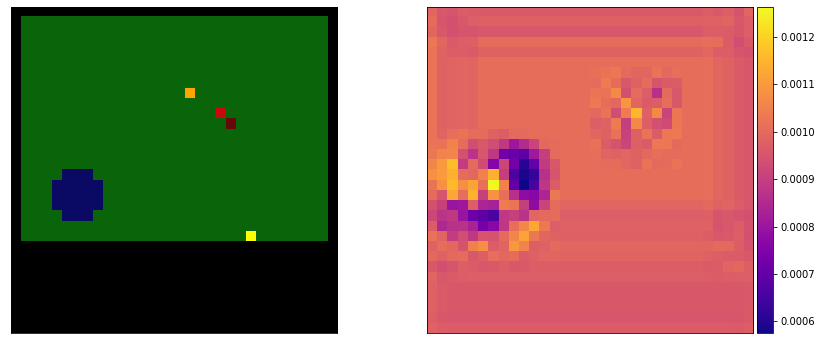


Step 17
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.63
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(20,18)
Action selected:  [2]
Move advantage: 0.0013


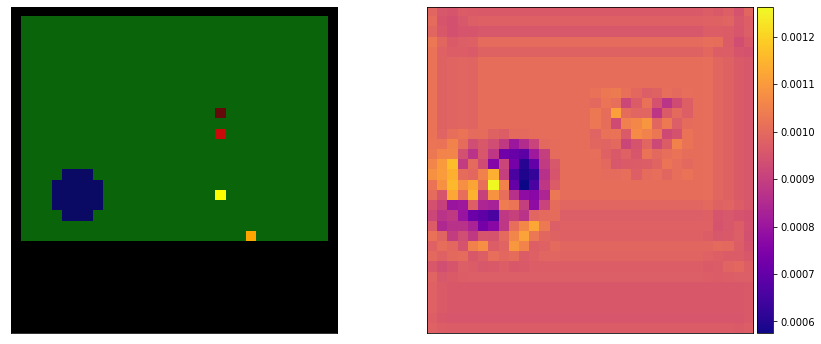


Step 18
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.63
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(15,12)
Action selected:  [2]
Move advantage: 0.0009


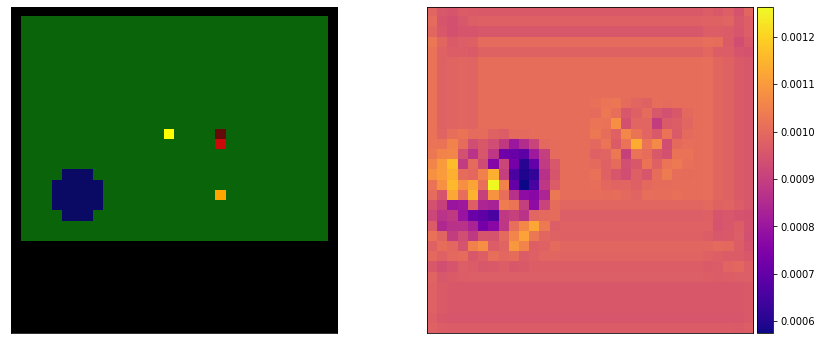


Step 19
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.54
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(9,19)
Action selected:  [2]
Move advantage: 0.0026


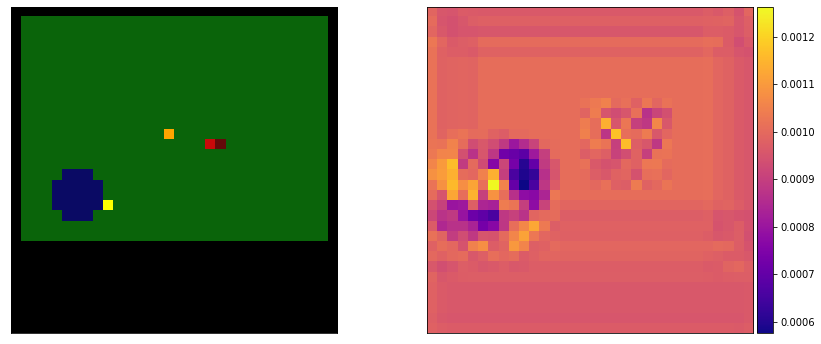


Step 20
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.62
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(2,1)
Action selected:  [2]
Move advantage: 0.0007


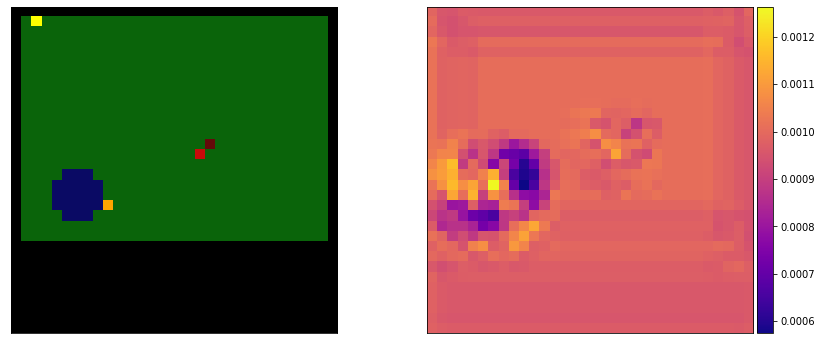


Step 21
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.56
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(11,11)
Action selected:  [2]
Move advantage: 0.0007


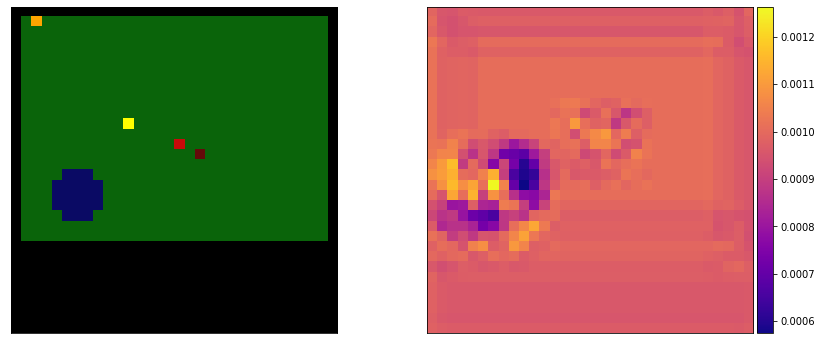


Step 22
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.57
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(18,1)
Action selected:  [2]
Move advantage: 0.0001


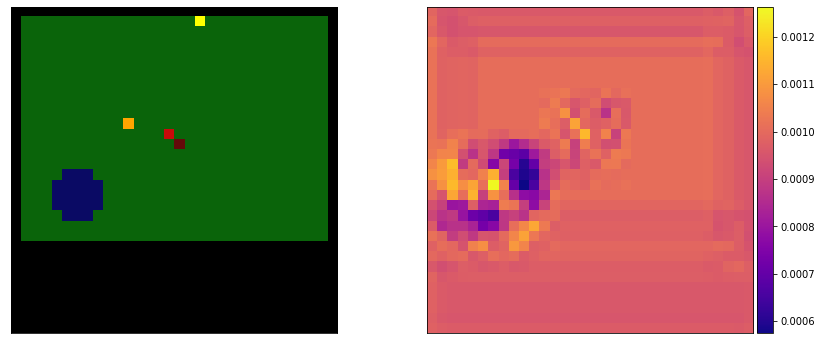


Step 23
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.63
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(26,16)
Action selected:  [2]
Move advantage: 0.0010


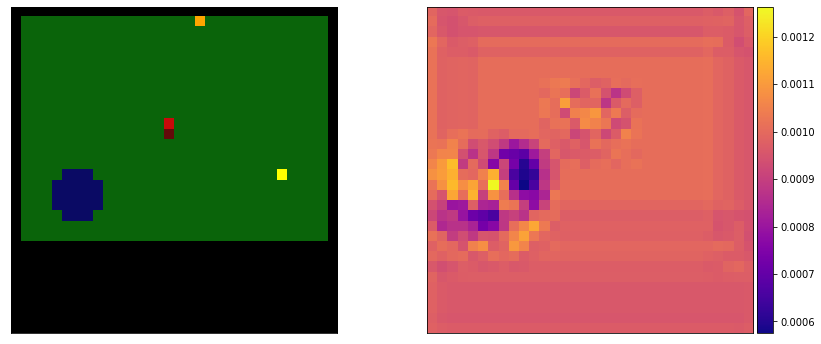


Step 24
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.61
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(31,2)
Action selected:  [2]
Move advantage: 0.0011


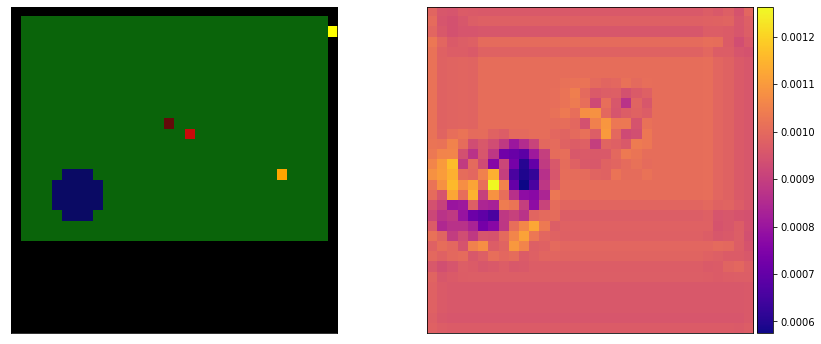


Step 25
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.60
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(16,19)
Action selected:  [2]
Move advantage: 0.0008


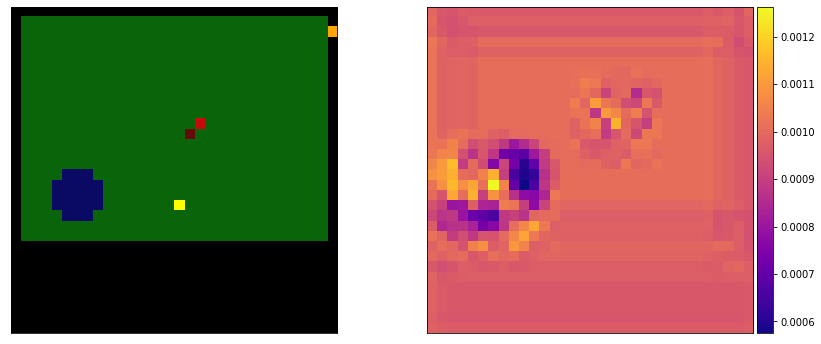


Step 26
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.56
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(5,20)
Action selected:  [2]
Move advantage: 0.0013


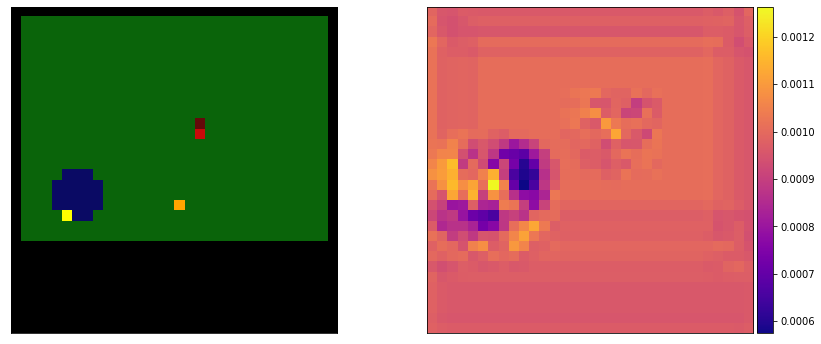


Step 27
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.58
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(19,17)
Action selected:  [2]
Move advantage: 0.0004


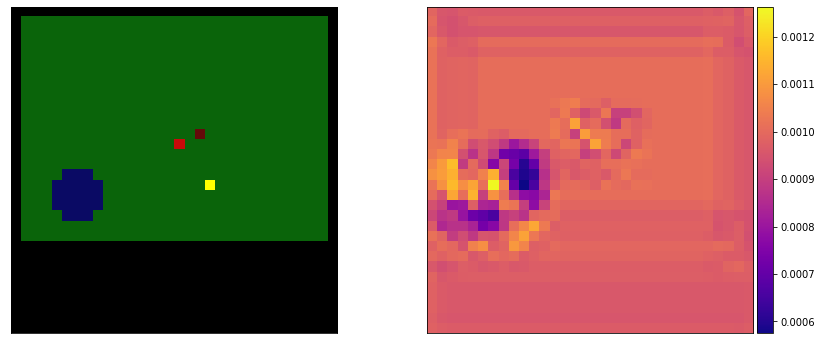


Step 28
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.58
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(6,18)
Action selected:  [2]
Move advantage: 0.0009


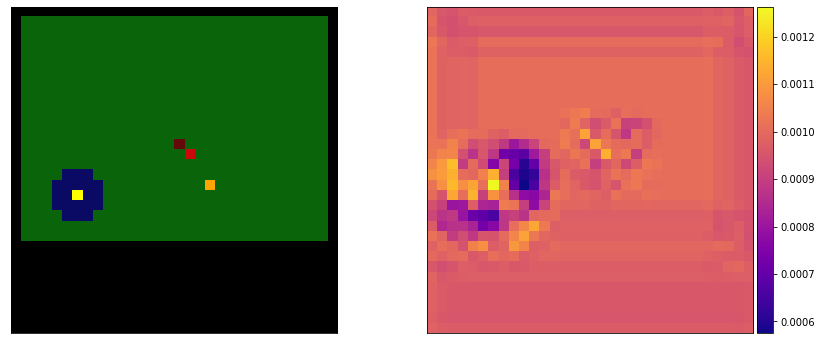


Step 29
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.60
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(11,15)
Action selected:  [2]
Move advantage: 0.0021


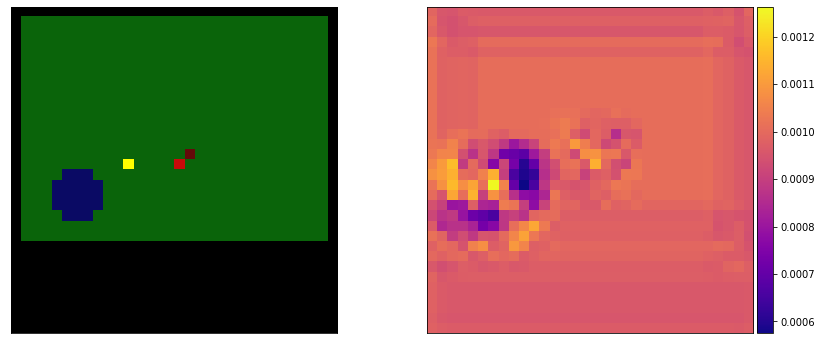


Step 30
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.58
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(4,21)
Action selected:  [2]
Move advantage: 0.0026


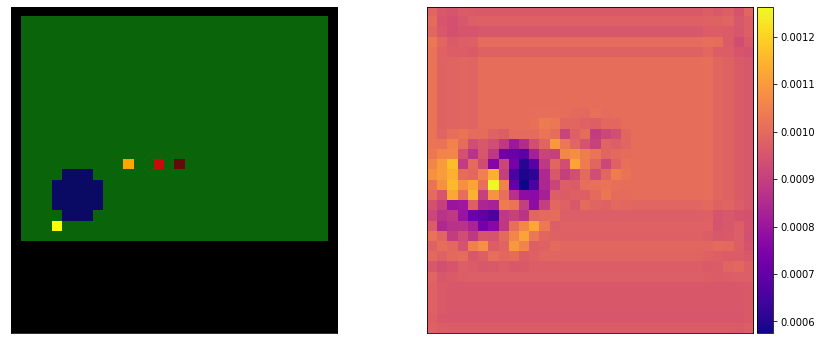


Step 31
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.63
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(29,16)
Action selected:  [2]
Move advantage: 0.0004


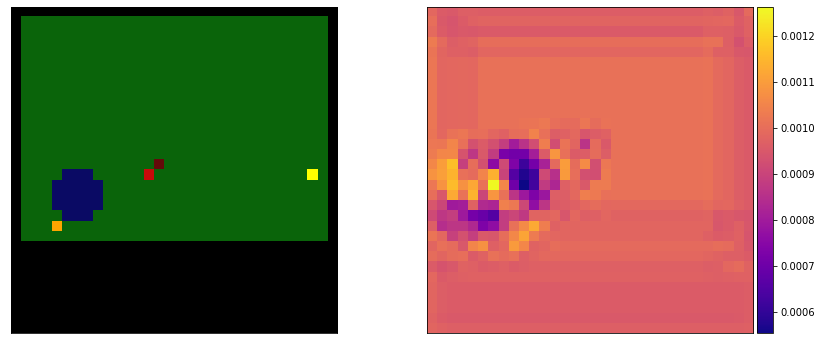


Step 32
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.58
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(24,31)
Action selected:  [2]
Move advantage: 0.0009


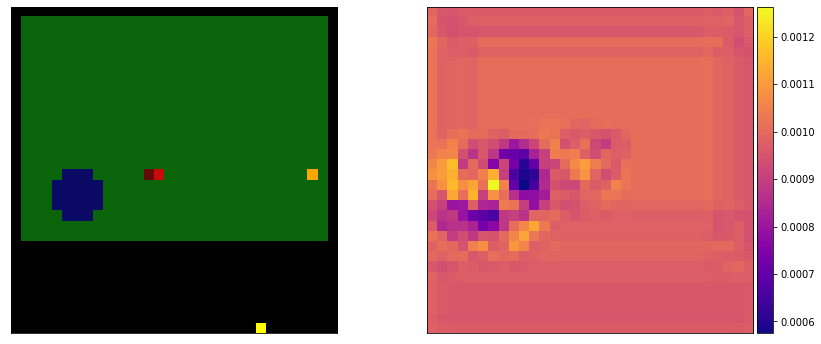


Step 33
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.62
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(19,22)
Action selected:  [2]
Move advantage: 0.0001


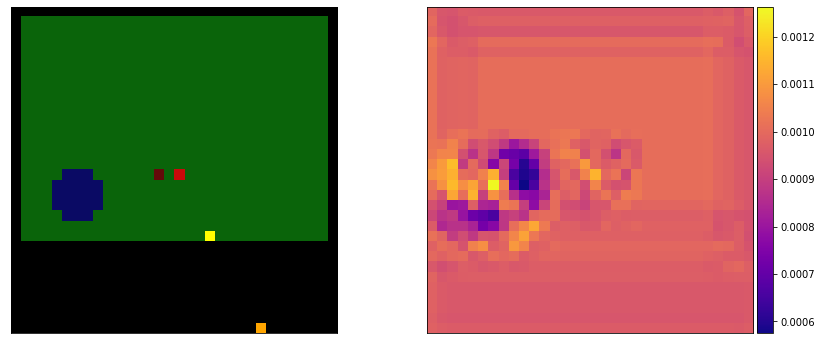


Step 34
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.58
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(7,2)
Action selected:  [2]
Move advantage: 0.0009


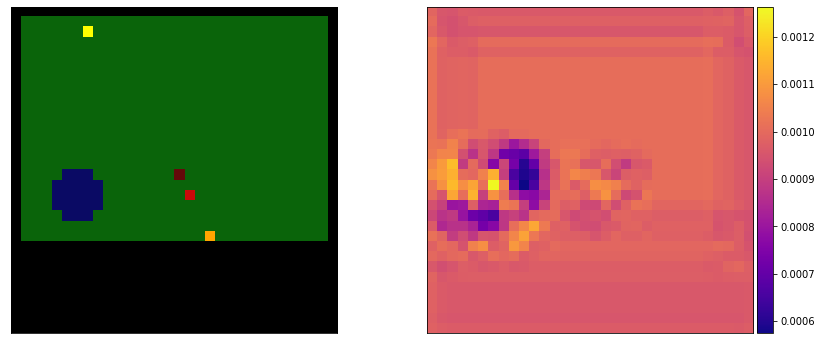


Step 35
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.62
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(29,13)
Action selected:  [2]
Move advantage: -0.0002


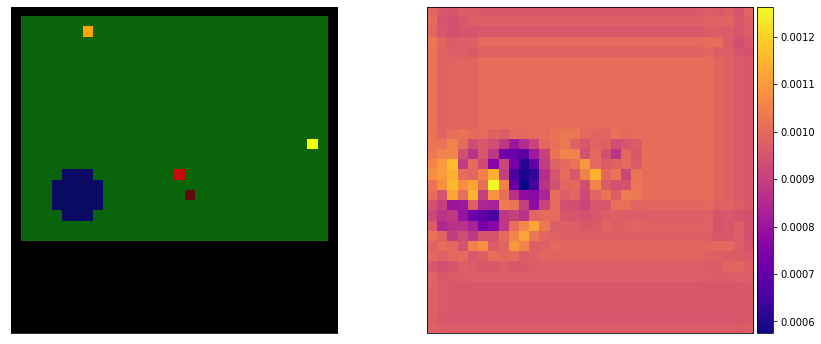


Step 36
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.60
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(30,6)
Action selected:  [2]
Move advantage: 0.0024


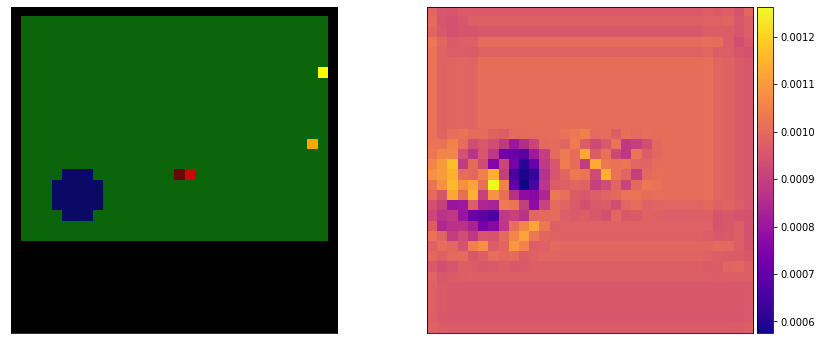


Step 37
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.56
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(5,0)
Action selected:  [2]
Move advantage: 0.0004


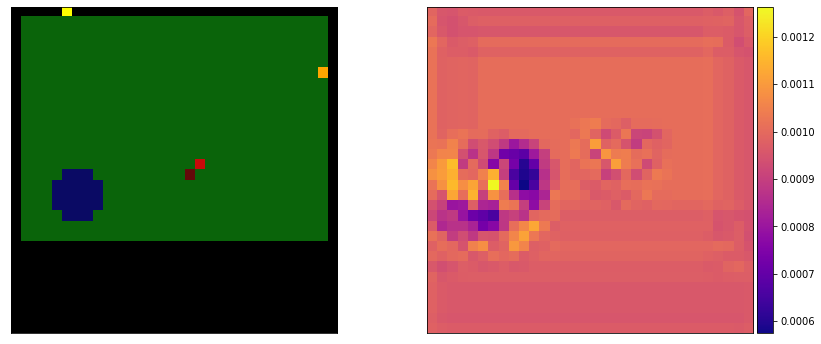


Step 38
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.58
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(3,2)
Action selected:  [2]
Move advantage: 0.0007


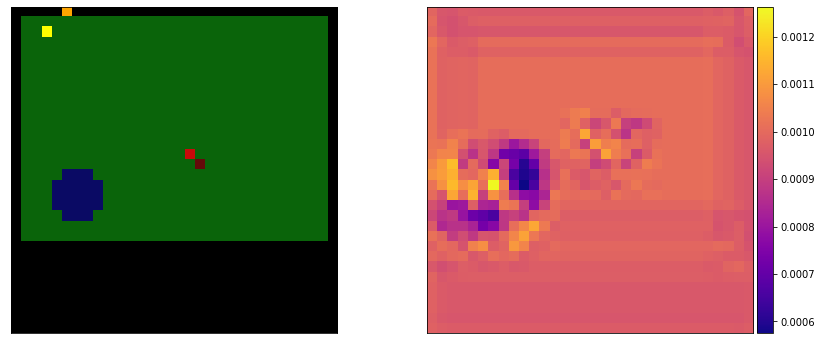


Step 39
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.59
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(11,20)
Action selected:  [2]
Move advantage: 0.0004


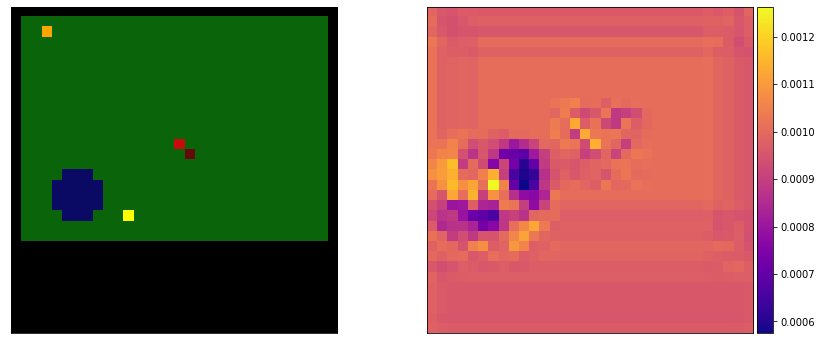


Step 40
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.60
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(3,8)
Action selected:  [2]
Move advantage: 0.0014


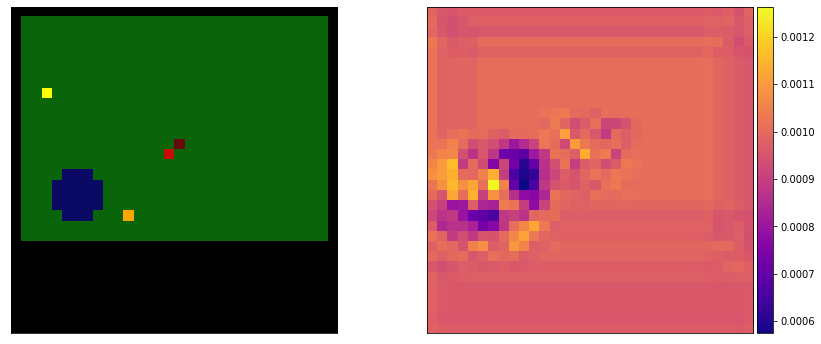


Step 41
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.57
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(14,22)
Action selected:  [2]
Move advantage: 0.0012


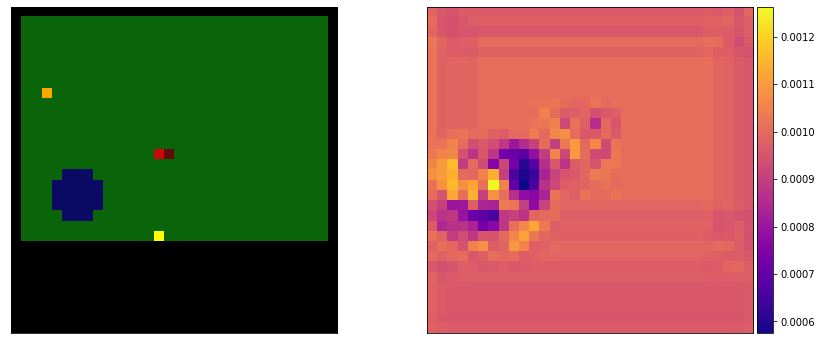


Step 42
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.60
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(16,19)
Action selected:  [2]
Move advantage: 0.0037


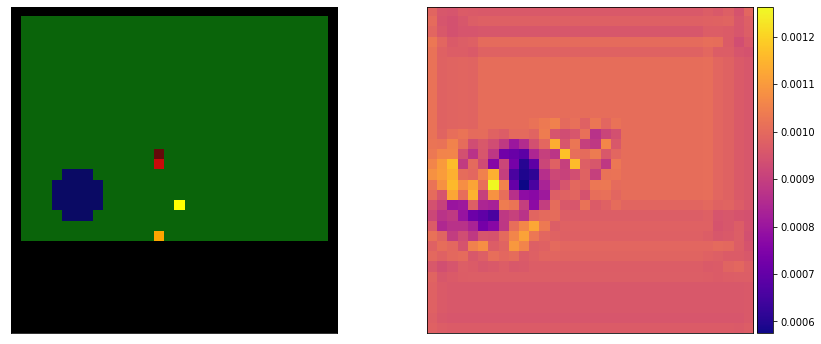


Step 43
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.61
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(17,8)
Action selected:  [2]
Move advantage: 0.0006


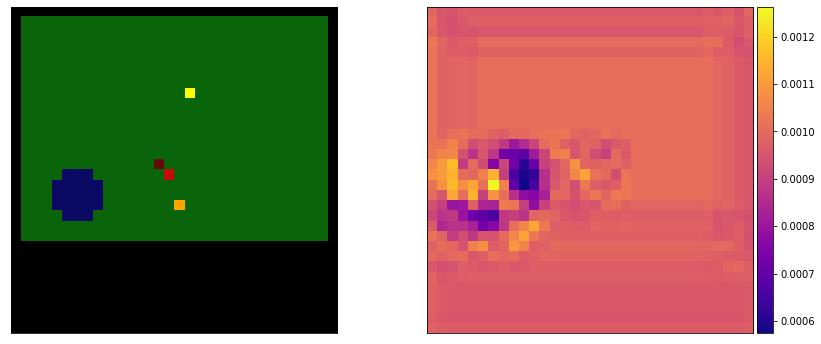


Step 44
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.61
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(9,21)
Action selected:  [2]
Move advantage: 0.0002


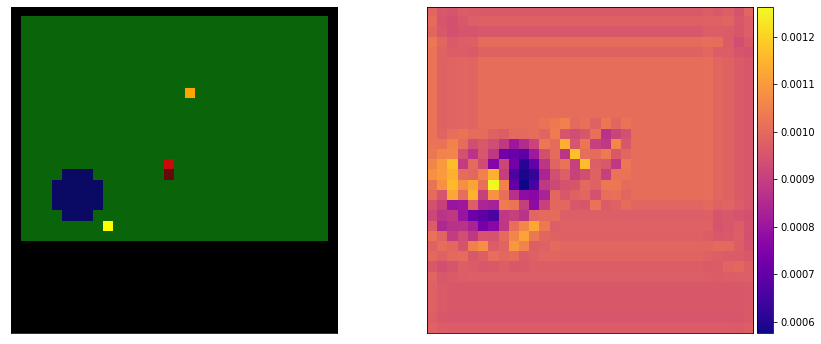


Step 45
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.65
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(24,14)
Action selected:  [2]
Move advantage: 0.0005


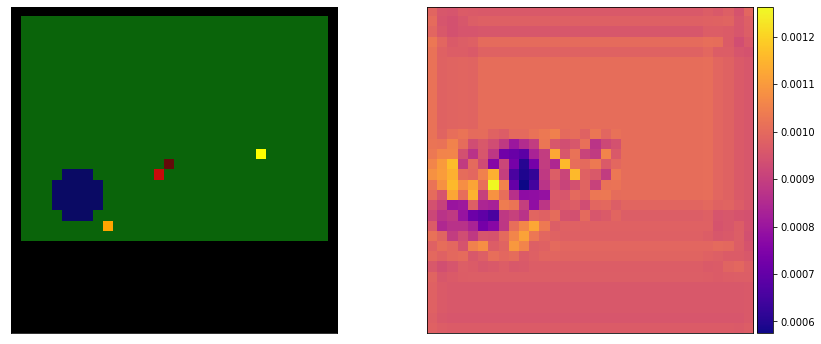


Step 46
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.61
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(25,13)
Action selected:  [2]
Move advantage: -0.0004


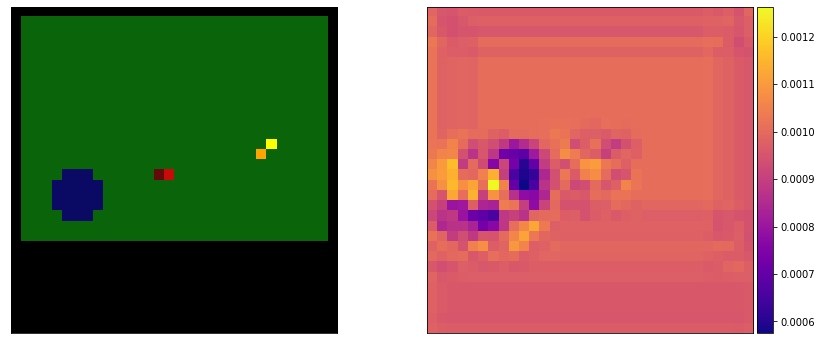


Step 47
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.61
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(15,15)
Action selected:  [2]
Move advantage: 0.0015


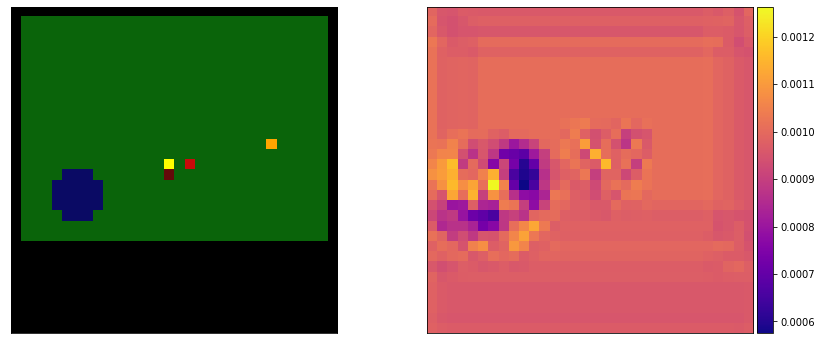


Step 48
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.61
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(13,0)
Action selected:  [2]
Move advantage: 0.0008


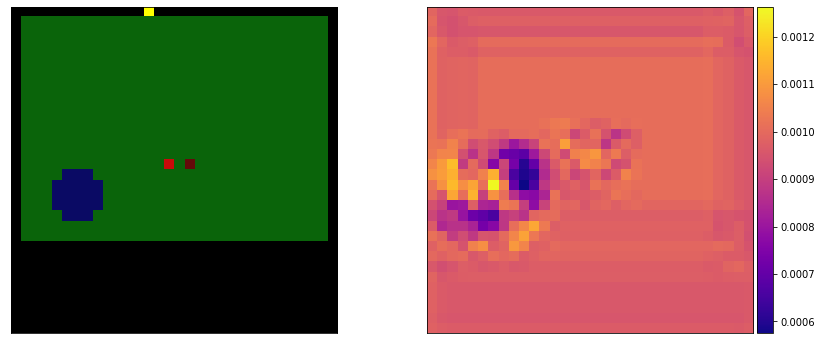


Step 49
_NO_OP: 	0.00
_SELECT_ARMY:  0.00 - _SELECT_ALL: 48.59
_MOVE_SCREEN:   100.00 - _NOT_QUEUED: 100.00 - POINT: (x,y)=(3,13)
Action selected:  [2]
Move advantage: 0.0014


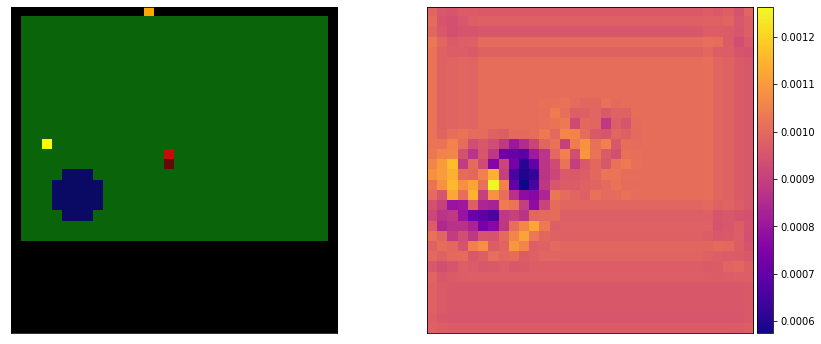

In [8]:
#for t in range(len(insp_dict['state_traj'])):
for t in range(50):
    print_action_info(insp_dict, t)
    plot_screen_and_decision(insp_dict, t)